# Week 5: Restricted Boltzmann Machine

**Group:** CCTS<br>

**Members**:
   + Chiara Maccani (2027591)
   + Samuele Piccinelli (2027650)
   + Tommaso Stentella (2027586)
   + Cristina Venturini (2022461)

# Introduction

In [1]:
import random
import numpy as np
from numpy import exp
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from scipy.stats import binom
from math import factorial
#from IPython.display import display, Markdown
plt.rc('font',**{'size':16, 'family':'serif','serif':['Computer Modern Roman']})
plt.rc('text', usetex=True)
plt.rc('mathtext', **{'fontset':'cm'})
plt.rc('axes', **{'titlesize':'large', 'labelsize':'large'})
plt.rc('xtick', labelsize = 16)
plt.rc('ytick', labelsize = 16)

%matplotlib inline
random.seed(123)
np.random.seed(12345)

# Function definition

## Generating data

The following functions are used to generate two types of data. Both will return $10000$ sequences of $8$ bit and take as input the probability of a bit to be flipped. 
In the first function every datum is generated by sampling randomly within a pool of the following strings:

0.  [11001100]
1.  [11000011]
2.  [00111100]
3.  [00110011]

that have an evident hidden stucture that we expect to be learned from the machine. 

The second function adds to these possibilities also the states:

4.   [11111111]
5.   [10101000]

which do not follow the pattern of the previous ones.

If the input probability is different from $0$ the generated data will be corrupted by flipping randomly every bit according to that probability.




In [2]:
N=10000
L=8
Z=int(L/4)

def gen_data(q):
    y = [0] * N
    x_r = [[0] * L for j in range(N)]
    x_c = [[0] * L for j in range(N)]
    vec1 = [1] * Z     

    def ones(n,i,j):
        x_r[n][Z*i:Z*(i+1)] = vec1
        x_r[n][Z*(j+2):Z*(j+3)] = vec1
        x_c[n][Z*i:Z*(i+1)] = vec1
        x_c[n][Z*(j+2):Z*(j+3)] = vec1
        
    random.seed(123)

    for n in range(N):
        a = random.randint(0,1)
        b = random.randint(0,1)
        y[n] = a+b*2
        ones(n,a,b)
        
        # add noise
        for j in range(L):
            if random.random()<q:
                 x_c[n][j] = 1-x_r[n][j]
                    
    return np.array(x_c), np.array(x_r) 

In [3]:
def gen_data2(q, categ):
    y = [0] * N
    x = [[0] * L for j in range(N)]
    
    sequences = {1:[0,1,0,0,1,1,0,0],2:[0,0,1,1,1,1,0,0],3:[1,1,0,0,0,0,1,1],
                 4:[0,0,1,1,0,0,1,1],5:[1,1,1,1,1,1,1,1],6:[1,0,1,0,1,0,0,0]}
    
    random.seed(123)
    
    for n in range(N):
        num = random.randint(1, categ)
        x[n] = np.array(sequences[num])         
            
        for j in range(L):
            if random.random()<q:
                 x[n][j] = 1-x[n][j]
    return np.array(x)

## Initializing weights

The following function is used to initialize the machine. Depending on the choice of representing bits as $\{0,1\}$ or $\{-1,1\}$ it encodes the input data and initializes the weights and biases according to the number of hidden units $M$ that is chosen.

In [4]:
def initialize(v, v_r, SPINS, M):
    N = len(v) 
    L = len(v[0])  

    if SPINS:
        vmin=-1   
        GAP = 2   
        v = 2*v - 1
        v_r = 2*v_r-1
    else:
        vmin = 0
        GAP = 1
    
    np.random.seed(12345)
    sigma = np.sqrt(4./float(L+M)) 
    w = sigma * (2*np.random.rand(L,M) - 1)
    a = sigma * (2*np.random.rand(L) - 1)
    b = np.zeros(M)
    v_out = copy.deepcopy(v)
    
    return v_out, v_r, w, a, b, vmin, GAP

## Visualization: monitoring RBM training

The following function is used to visualize the weights and biases during the training.

In [5]:
def create_coord(np, x0):
    x = [x0] * np 
    y = list(range(np))
    for i in range(np):
        y[i] = y[i]/(np-1.) - 0.5   
    return (x,y)

def mycolor(val):
    if val>0: return 'r'
    elif val<0: return 'b'
    else: return 'k'

def plotgraph(w,a,b,epoch=0, M=3):
    (x1 , y1) = create_coord(L,0)
    (x2 , y2) = create_coord(M,1)
    plt.figure(figsize=(7,5))
    A = 2./w.max()
    for i in range(L):       
        for j in range(M):  
            ex, ey, col = (x1[i], x2[j]) , (y1[i], y2[j]), mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*np.abs(w[i][j]))  
    A = 300./np.abs(a.max() + b.max())
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*np.abs(a[i]), zorder=2, c=mycolor(a[i]))   
    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*np.abs(b[j]), zorder=2, c=mycolor(b[j]))
    plt.title(f'$>0$ red, $<0$ blue, epoch = {epoch}', size=20)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [6]:
def plot_weights(N, mini, nepoch, weights, title=None):
    plt.figure(figsize=(16,5))
    x_ax = range(int(N/mini*nepoch))
    plt.scatter(x_ax, weights, s=8, alpha=0.4, color='r')
    plt.title(title, size=22)
    plt.xlabel(r'$\frac{N\times \mathrm{epochs}}{\mathrm{mini}}$', size=18)
    plt.ylabel(r'$\log(\langle dw^2\rangle)$', size=18)
    plt.yscale('log')
    plt.grid(True)
    plt.show()

## Training a RBM

In [7]:
def activate(v_in, wei, bias, DE, vmin, beta=1, info = False):
    act = np.dot(v_in, wei) + bias
    prob = 1. / (1. + exp(-DE*act*beta))
    n = len(act)
    v_out = np.full(n,vmin)
    v_out[np.random.random_sample(n) < prob] = 1
    if info:
        print(f'Input: {v_in}\nActivation: {act}\nProbability: {prob}\nOut: {v_out}')
    return v_out, prob

In [8]:
def train_RBM(v, a, b, w, vmin, GAP, nepoch, mini, M, beta=1, info=True):
    np.random.seed(12345)
    l_rate=1.0
    m = 0
    weights_increment, hidden_probabilities, visible_probabilities = [], [], []
    for epoch in range(1,1+nepoch):
        for n in range(N):
            if m==0:
                v_data, v_model = np.zeros(L), np.zeros(L)
                h_data, h_model = np.zeros(M), np.zeros(M)
                vh_data, vh_model = np.zeros((L,M)), np.zeros((L,M))
            # positive CD phase
            h, p_h = activate(v[n], w, b, GAP, vmin, beta=beta)
            # negative CD phase (fantasy particle)
            vf, p_vf = activate(h, w.T, a , GAP, vmin, beta=beta)
            # positive CD phase nr 2
            hf, p_hf = activate(vf, w, b, GAP, vmin, beta=beta)

            hidden_probabilities.append(p_h)
            visible_probabilities.append(p_vf)

            v_data += v[n]
            v_model += vf
            h_data += h 
            h_model += hf
            vh_data += np.outer(v[n].T, h)
            vh_model += np.outer(vf.T, hf)
            m+=1

            if m==mini:
                C = l_rate/mini
                dw = C * (vh_data-vh_model)
                da = C * (v_data-v_model)
                db = C * (h_data-h_model)
                w += dw
                a += da
                b += db
                s=0

                for i in range(L):
                    for j in range(M):
                        s+=dw[i][j]**2
                weights_increment.append(s/(L*M))
                m = 0
        # randomize order
        np.random.shuffle(v)
        l_rate = l_rate / (0.05 * l_rate + 1)
        if epoch%5==0 and info:
            plotgraph(w, a, b, epoch, M)
#             print(f'Learning rate: %.3f'%l_rate)
            
    return a, b, w, np.array(weights_increment), np.array(hidden_probabilities), np.array(visible_probabilities)

## Verifying bit correction

After the training and the generation of new fantasy data, some functions are needed to evaluate the performances. 

The following is used to count how many samples among the fantasy ones consist of a string that agrees with the set of sequences used to generate the initial data, telling whether each new sample is plausible or not.


In [9]:
def plausibility(v, GAP, N, fourth=False, fifth=False):
    pl = np.empty(N)
    
    key1 = np.array([1,1,0,0,1,1,0,0])
    key2 = np.array([0,0,1,1,1,1,0,0])
    key3 = np.array([1,1,0,0,0,0,1,1])
    key4 = np.array([0,0,1,1,0,0,1,1])
    key5 = np.array([1,1,1,1,1,1,1,1])
    key6 = np.array([1,0,1,0,1,0,0,0])
    if GAP == 2:
        v = (v+1)/2 # shift back
    
    pl = (v==key1).all(1) + (v==key2).all(1) + (v==key3).all(1) + (v==key4).all(1)
    
    if fourth:
        pl += (v==key5).all(1)
    elif fifth:
        pl += (v==key5).all(1) + (v==key6).all(1)
    
    true = np.sum(pl)
    false = len(pl)-true
    print('Number of plausible samples: %.2f%%'%(true*100/(true+false)))
    print('Number of not plausible samples: %.2f%%'%(false*100/(true+false)))

The function `distance` is used to compare each pair of samples of two different sets counting the number of different bits. The mean value of the vector of distances can be interpreted as a measure of the similarity of the two sets (the least differences there are in the data, the lower is the average value of the distances).

In [10]:
def distance(v, x, N, GAP, info=True):
    if GAP == 2:
        v = (v+1)/2 # shift back (both corrupted&non-corrupted)
        x = (x+1)/2

    d = np.empty(N)
    d = np.abs(v - x).sum(1)
    bins = int((np.abs(d.max()-d.min()))+1)
    if info:
        plt.figure(figsize=(7,5))
        plt.xlabel('Distance', size=18)
        plt.ylabel('Counts', size=18)
        plt.hist(d, bins=np.arange(bins)-0.5, range=(d.min(), d.max()+1), histtype='step', color='k')
        plt.grid(True)
        plt.show()
        for i in range(0,int(d.max())):
            print(f'Num. of samples @ dist = {i}:\t',len(d[d==i]))
    return d

The function below plots the heatmap of the conditional probability of a single variable being $1$ encoded in grey scale: this is interpreted as the firing rate of a neuron. Effectively, the value plotted are the results of the each input multiplied by its own weight going through the sigmoid activation function.

In [11]:
def prob_heatmap(ph, mini=50):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    ax1 = sns.heatmap(ph[0:mini,:], cmap='Greys', linewidths=.5, yticklabels = 10, ax=ax1)
    ax1.set_xlabel('Hidden units', size=18) 
    ax1.set_ylabel('Samples', size=18)
    ax1.set_title('First minibatch', size=22)
    ax2 = sns.heatmap(ph[-mini:,:], cmap='Greys', linewidths=.5, yticklabels = 10, ax=ax2)
    ax2.set_xlabel('Hidden units', size=18) 
    ax2.set_ylabel('Samples', size=18)
    ax2.set_title('Last minibatch', size=22)
    plt.show()

The following function is used to compare the distance between the original samples and the corresponding corrupted ones and the distance between the same original samples and the corrisponding fantasy ones. <br> 
To give an idea of how well the trained RBM does bit correction, depending on how corrupted is the data it receives is input, we use a heatmap. It returns the fraction of samples that have not been denoised. 

In [12]:
def dist_heatmap(d0,d):
    a = np.zeros((9,9))
            
    for n in range(N): a[int(d0[n])][int(d[n])]+=1
    tot = 0    
    for i in range(9):
        for j in range(1,9):
            tot+=a[i][j]

    fig, ax= plt.subplots(figsize=(12,6))
    ax = sns.heatmap(a*100/N, cmap='coolwarm', annot=True, fmt='.1f', annot_kws={"fontsize":18}, linewidths=.5, ax=ax)
    for t in ax.texts: t.set_text(t.get_text() + " \%")
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 20, 40, 60, 80, 100])
    cbar.set_ticklabels(['0\%', '20\%', '40\%', '60\%', '80\%', '100\%'])

    ax.set_xlabel('Distance real/new samples', size = 18)
    ax.set_ylabel('Distance real/corrupted samples', size = 18)
    
    print('Mean distance real/corrupted samples: %.3f'%d0.mean())
    print('Mean distance real/new samples: %.3f'%d.mean())
    
    plt.show()
    print('Fraction of sample not truly corrected: %.2f%%'%(tot*100/N))

## Sistematic hyper-parameter search

The function `grid` is used to evaluate the machine performances with different parameters. This is done by training the machine for every set of parameters and then calculating the mean distance (as explained above) between the real data and the denoised version given by the machine output. Please notice that parameter `beta` is not used in the training process, but only in the denoising one.


In [94]:
def grid(x_c, x_r, SPIN, M, nepoch, minis, betas):
    best_params, best = 0, 16
    for spin in SPIN:
        if spin:
            v0 = 2*x_c - 1
        else:
            v0 = copy.deepcopy(x_c)The function `grid` is used to evaluate the machine performances with different parameters. This is done by training the machine for every set of parameters and then calculating the mean distance (as explained above) between the real data and the denoised version given by the machine output. Please notice that parameter `beta` is not used in the training process, but only in the denoising one.

        for m in M:
            for mini in minis:
                v_c, v_r, w, a, b, vmin, GAP = initialize(x_c, x_r, spin, m)
                a, b, w, dw, hp_grid, vp_grid = train_RBM(v_c, a, b, w, vmin, GAP, nepoch, mini, m, info=False)
                v_test = np.full((N,L), vmin)
        
                for beta in betas:
                    for n in range(N):
                        h, h_prob = activate(v0[n], w, b, GAP, vmin, beta)
                        v_test[n], v_prob = activate(h, w.T, a, GAP, vmin, beta)

                    dist = distance(v_test, v_r, N, GAP, info=False)
                    print('SPIN:', spin, 'M:', m, ' minibatch:', mini, ' beta:', beta,'\tdistance: %.3f' % dist.mean())
                    if best > dist.mean():
                        best = dist.mean()
                        best_params = {'SPIN': spin, 'M': m, 'minibatch': mini, 'beta': beta}         
    return best_params

# General overview

The next sections are organized as follows:

- **Sec. 1.**: we deal with data in $\{-1, 1\}$ and $q = 0.1$: for each case a systematic parameter search is carried out in order to find the set leading to the smallest distance between the original data (without noise) and the denoised set originated from the hidden layer. To measure the gap between the $2$ the element-wise difference of the $2$ vectors is computed: the elements of the resulting $8$-bit long vector are summed altogether, leading to the searched difference.
    + **Sec. 1.1.**: we handle the base case with $4$ sample categories: after generating the data and training the RBM we generate the fantasy data and introduce a higher $\beta$ factor (i.e. a lower “temperature” in the sigmoid function) first in the negative phase only and later in both positive and negative phase of the training in order to assess if bit correction is working as expected.
    + **Sec. 1.2.**: we introduce a $5^{\mathrm{th}}$ state and train the RBM after searching for the minimum number of layers required to reach convergence: we evaluate the behaviour of the trained net for bit correction - this time with a higher $\beta$ in both the negative and positive phase.
    + **Sec. 1.3.**: we repeat the process for a $6^{\mathrm{th}}$ state.
- **Sec. 2.**: we repeat the whole process for data in $\{-1, 1\}$ but with a larger error rate of $q = 0.2$ and compare the results obtained with those of the previous section in points **2.1.**, **2.2.**, **2.3.**.

- **Sec. 3.**: we compare the convergence of the RBM parameters for the $2$ cases of spin encoding (data in $\{-1, 1\}$) and bit encoding (data in $\{0, 1\}$): this is done by showing the mean square increment $\langle dw^2\rangle$ of weights versus time.

# 1. First training: data in $\{-1, 1\}$, $q = 0.1$

## 1.1. Base case: $4$ sample categories

In this section we use the first generating function that presents $4$ types of states and input probability of flipping equal to  $10\%$. <br>
In order to find the optimal number of samples in a minibatch, we estimate approximately the number of categories appearing in the data after the corruption. This is because according to [1] "For datasets that contain a small number of equiprobable classes, the ideal mini-batch size is often equal to the number of classes and each mini-batch should contain one example of each class to reduce the sampling error when estimating the gradient for the whole training set from a single mini-batch". <br>
Actually, in our case, the number of classes quickly increases with the number of flips, not guaranteeing the conditions cited in the paper regarding a "small number of classes". <br>
Furthermore, the classes are not equiprobable. That is, intrinsically, the classes obtained with $j$ flips ($j \in [0,1,2,3,4,5]$) are equiprobable if taken individually but it is not realistic to say that we can have a case in which we only have $1$ flip on every sample of our dataset, or only $0$ flip, or only $2$ flips. <br>
This is why when we declare the number of categories with a certain number of flips $j$ we are actually stating a cumulative number: for example, there are $32$ possible combinations with $1$ flip but we also sum the $4$ categories regarding $0$ flips because they are more likely to happen and so it's fair to assume that if there's $1$ flip there will also be $0$ flips. This reasoning can be repeated for each number of flips $j$ and is justified by the fact that probabilities are either decreasing (for $q=0.1$) or anyhow similar, forcing to include at least $0$ and $1$ flip cases to cover most of the categories. Notice that, however, these numbers are only approximately correct. In particular they are overestimated by not taking into account the possibility that, with the increasing of the number of flips, the category obtained by flipping some bits of an original one could be equal to the one obtained by flipping another initial state.<br>
Because of this, we decided to keep the considerations from the paper as a possible indication of an ideal size for the minibatch. We therefore included the number of samples in a minibatch as a parameter (`mini`) to our grid search to find the optimal value. 


[1] Geoffrey Hinton, A Practical Guide to Training Restricted Boltzmann Machines. UTML TR 2010–003, University of Toronto (2010)

In [14]:
q = 0.1
n_categ = 4
max_flip = 0
nepoch = 50

for i in range(1,9):
    flips = binom.pmf(i, 8, q) * N
    if flips < 1 and max_flip == 0:
        max_flip = i-1

print('# categories with %i flips: %i \t\tprobability of %i flips: %.2f%%'%(0, 4, 0, 100*binom.pmf(0,8,q)))
for i in range(1, max_flip+1):
    n_categ = n_categ + 4*factorial(8)/factorial(8-i)/factorial(i)
    print('# categories with %i flips: %i \t\tprobability of %i flips: %.2f%%'%(i, n_categ, i, 100*binom.pmf(i,8,q)))

# categories with 0 flips: 4 		probability of 0 flips: 43.05%
# categories with 1 flips: 36 		probability of 1 flips: 38.26%
# categories with 2 flips: 148 		probability of 2 flips: 14.88%
# categories with 3 flips: 372 		probability of 3 flips: 3.31%
# categories with 4 flips: 652 		probability of 4 flips: 0.46%
# categories with 5 flips: 876 		probability of 5 flips: 0.04%


In [15]:
SPIN = [True]
M = [2,3,4]
minis = [36, 50, 150, 372, 500]
betas = [0.5, 1, 10, 20]

v0, v_r = gen_data(q)
best_parameters = grid(v0, v_r, SPIN, M, nepoch, minis, betas)

SPIN: True M: 2  minibatch: 36  beta: 0.5 	distance: 2.154
SPIN: True M: 2  minibatch: 36  beta: 1 	distance: 0.908
SPIN: True M: 2  minibatch: 36  beta: 10 	distance: 0.233
SPIN: True M: 2  minibatch: 36  beta: 20 	distance: 0.232
SPIN: True M: 2  minibatch: 50  beta: 0.5 	distance: 2.167
SPIN: True M: 2  minibatch: 50  beta: 1 	distance: 0.916
SPIN: True M: 2  minibatch: 50  beta: 10 	distance: 0.232
SPIN: True M: 2  minibatch: 50  beta: 20 	distance: 0.234
SPIN: True M: 2  minibatch: 150  beta: 0.5 	distance: 2.252
SPIN: True M: 2  minibatch: 150  beta: 1 	distance: 0.975
SPIN: True M: 2  minibatch: 150  beta: 10 	distance: 0.232
SPIN: True M: 2  minibatch: 150  beta: 20 	distance: 0.233
SPIN: True M: 2  minibatch: 372  beta: 0.5 	distance: 2.278
SPIN: True M: 2  minibatch: 372  beta: 1 	distance: 1.001
SPIN: True M: 2  minibatch: 372  beta: 10 	distance: 0.240
SPIN: True M: 2  minibatch: 372  beta: 20 	distance: 0.236
SPIN: True M: 2  minibatch: 500  beta: 0.5 	distance: 2.279
SPIN

In [16]:
best_parameters

{'SPIN': True, 'M': 3, 'minibatch': 36, 'beta': 20}

In [107]:
#best_parameters = {'SPIN': True, 'M': 3, 'minibatch': 36, 'beta': 20}

### Generate data and train RBM

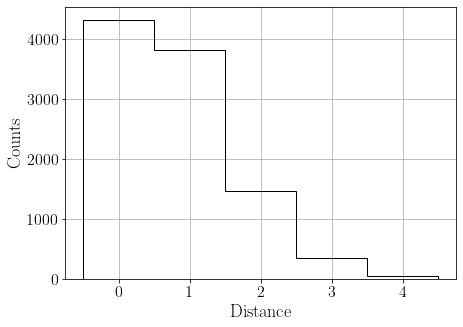

Num. of samples @ dist = 0:	 4321
Num. of samples @ dist = 1:	 3816
Num. of samples @ dist = 2:	 1468
Num. of samples @ dist = 3:	 349
Num. of samples @ dist = 4:	 42


In [18]:
M = best_parameters['M']
mini = best_parameters['minibatch']
beta = best_parameters['beta']
SPIN = True

v, v_r, w, a, b, vmin, GAP = initialize(v0, v_r, SPIN, M)
d0 = distance(v, v_r, N, GAP)
if SPIN:
    v0 = v0*2 - 1

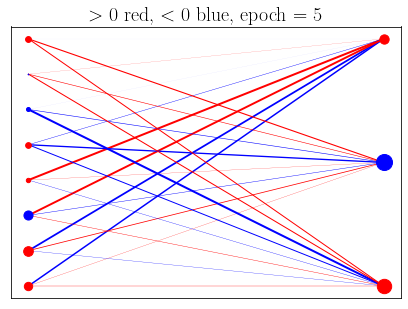

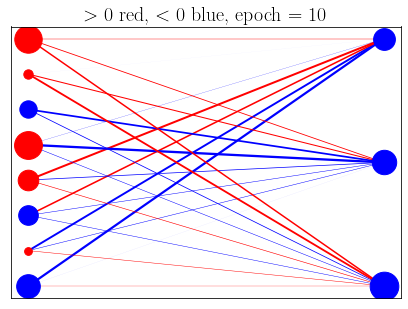

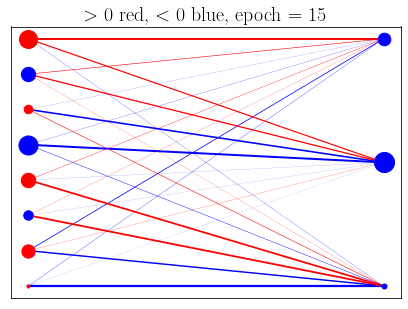

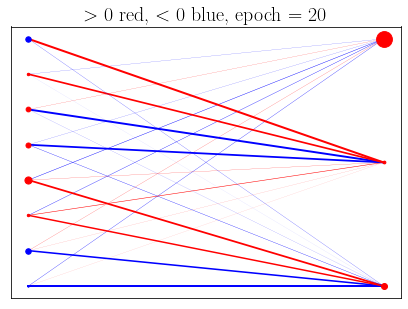

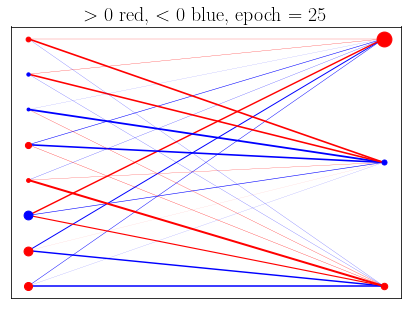

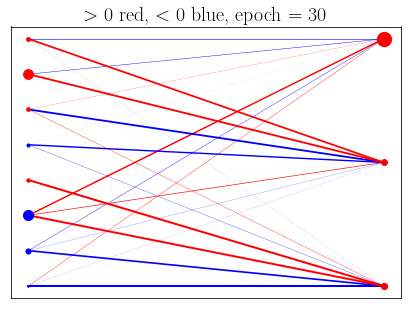

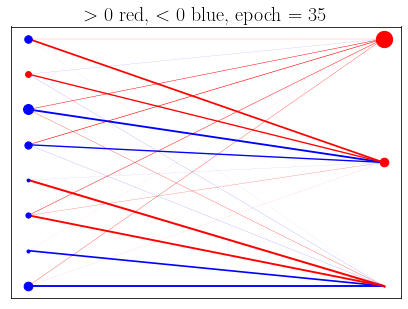

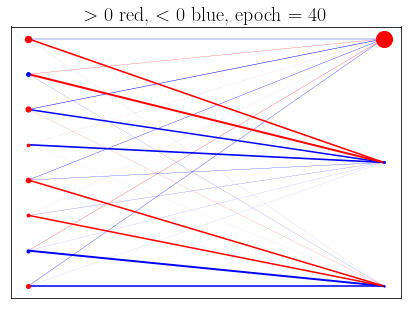

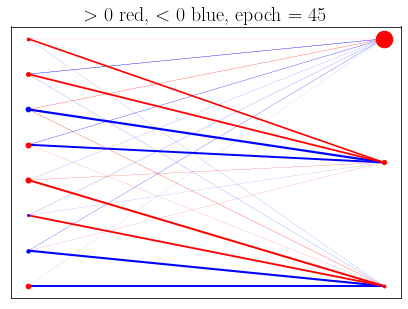

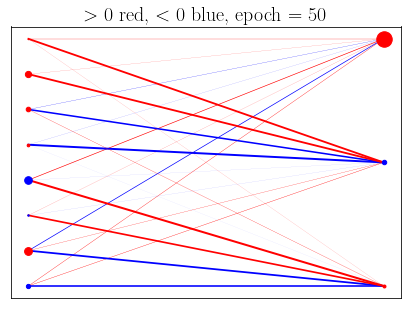

In [19]:
a, b, w, dw, prob_hidden, prob_vis = train_RBM(v, a, b, w, vmin, GAP, nepoch, mini, M)

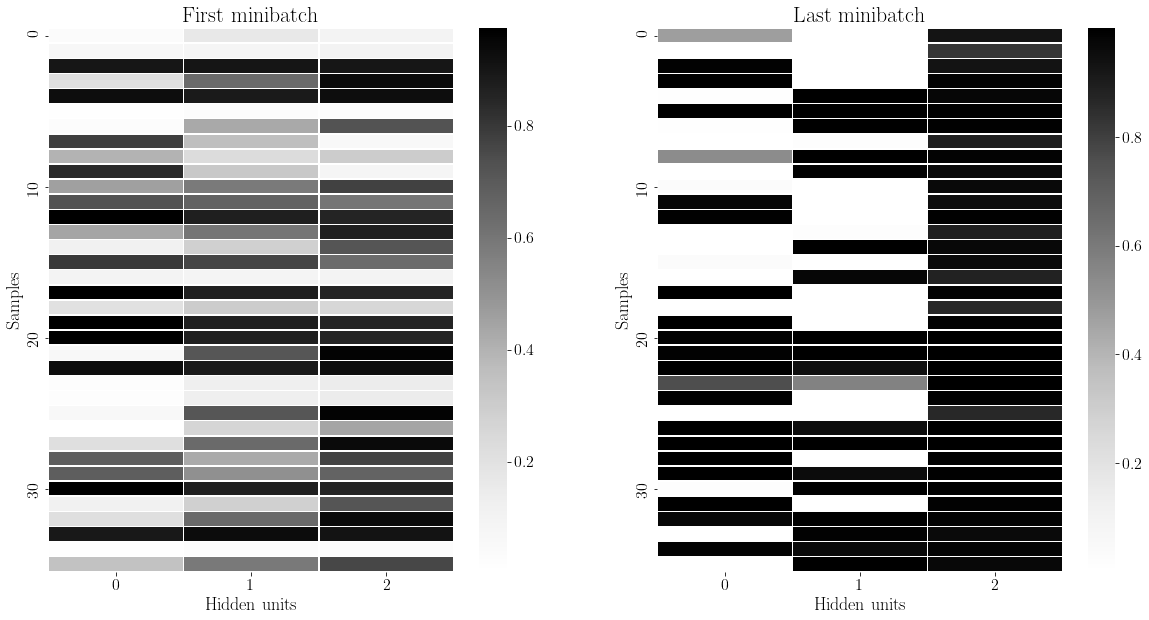

In [20]:
prob_heatmap(prob_hidden, mini)

The heatmpap above shows how at the beginning of training the value of probability associated to each hidden unit can have a more variegate set of values. At the end of training on the other hand, the values are more polarized towards $0$ or $1$. 

The plot below, showing the evolution of the mean square increment of the sum of the weights, will be further commented in the last section.

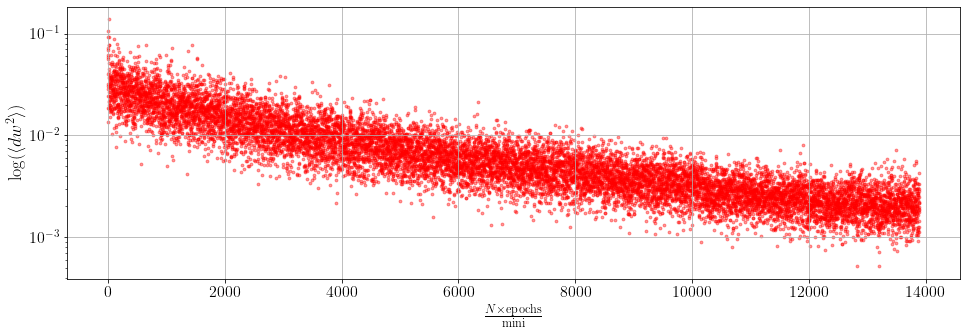

In [21]:
plot_weights(N, mini, nepoch, dw)

In [22]:
first_mini = copy.deepcopy(mini)
first_dw = copy.deepcopy(dw)

### Generate fantasy data and check bit correction: negative phase

At first, we use a higher value of $\beta$ only during the negative phase, for the generation of fantasy data.

In [23]:
fd = np.full((N,L), vmin)

for n in range(N):
    h, p_h = activate(v0[n], w, b, GAP, vmin)
    fd[n], p_fd = activate(h, w.T, a, GAP, vmin, beta=beta)

In [24]:
plausibility(fd, GAP, N)

Number of plausible samples: 99.94%
Number of not plausible samples: 0.06%


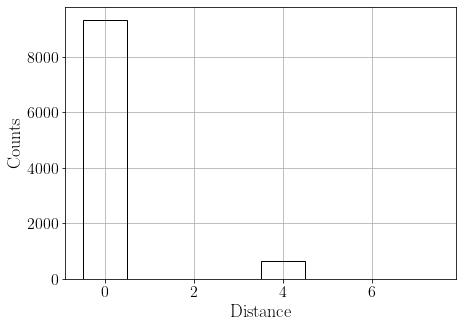

Num. of samples @ dist = 0:	 9339
Num. of samples @ dist = 1:	 6
Num. of samples @ dist = 2:	 0
Num. of samples @ dist = 3:	 0
Num. of samples @ dist = 4:	 641
Num. of samples @ dist = 5:	 0
Num. of samples @ dist = 6:	 0
Num. of samples @ dist = 7:	 0


In [25]:
d = distance(fd, v_r, N, GAP)

Mean distance real/corrupted samples: 0.799
Mean distance real/new samples: 0.268


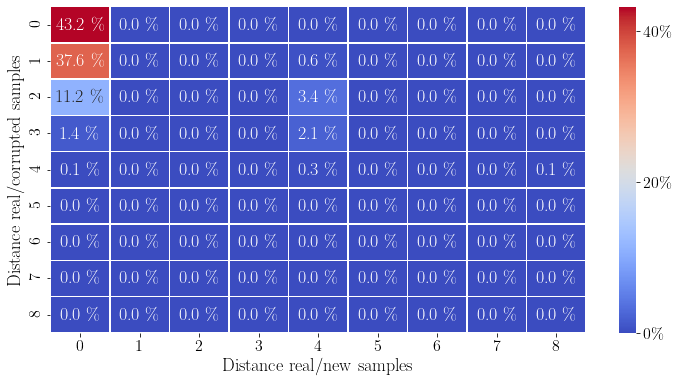

Fraction of sample not truly corrected: 6.61%


In [26]:
not_corr = dist_heatmap(d0,d)

### Generate fantasy data and check bit correction: positive and negative phase

We now add a higher beta even in the positive phase.

In [27]:
fd = np.full((N,L), vmin)

for n in range(N):
    h, p_h = activate(v0[n], w, b, GAP, vmin, beta=beta)
    fd[n], p_fd = activate(h, w.T, a, GAP, vmin, beta=beta)

In [28]:
plausibility(fd, GAP, N)

Number of plausible samples: 100.00%
Number of not plausible samples: 0.00%


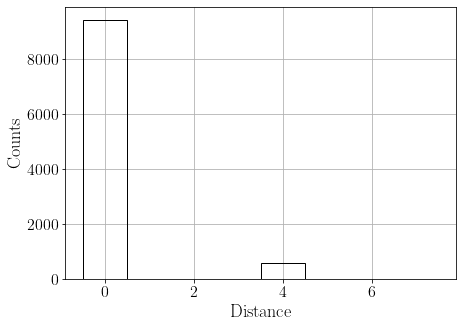

Num. of samples @ dist = 0:	 9434
Num. of samples @ dist = 1:	 0
Num. of samples @ dist = 2:	 0
Num. of samples @ dist = 3:	 0
Num. of samples @ dist = 4:	 559
Num. of samples @ dist = 5:	 0
Num. of samples @ dist = 6:	 0
Num. of samples @ dist = 7:	 0


In [29]:
d = distance(fd, v_r, N, GAP)

As can be seen from the graph above, 94% of data is correctly reconstructed.

Mean distance real/corrupted samples: 0.799
Mean distance real/new samples: 0.229


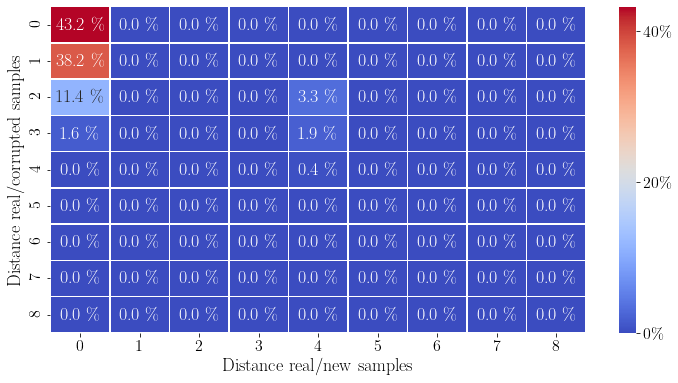

Fraction of sample not truly corrected: 5.66%


In [30]:
not_corr = dist_heatmap(d0,d)

In both cases (higher $\beta$ only for negative phase or for both phases) the results we obtain are good, with a percentage above $93\%$ of correct reconstruction of data. <br>
When using a higher $\beta$ in both phases the result slightly improves ($\sim94\%$ corrected samples). <br>
For this reason, from now on we use $\beta\neq 1$ for both phases. 

## 1.2. Introducing more categories: $5$ sample categories

In [31]:
n_categ = 5
max_flip = 0

for i in range(1,9):
    flips = binom.pmf(i, 8, q) * N
    if flips < 1 and max_flip == 0:
        max_flip = i-1

print('# categories with %i flips: %i \t\tprobability of %i flips: %.2f%%'%(0, 5, 0, 100*binom.pmf(0,8,q)))
for i in range(1, max_flip+1):
    n_categ = n_categ + 5*factorial(8)/factorial(8-i)/factorial(i)
    print('# categories with %i flips: %i \t\tprobability of %i flips: %.2f%%'%(i, n_categ, i, 100*binom.pmf(i,8,q)))

# categories with 0 flips: 5 		probability of 0 flips: 43.05%
# categories with 1 flips: 45 		probability of 1 flips: 38.26%
# categories with 2 flips: 185 		probability of 2 flips: 14.88%
# categories with 3 flips: 465 		probability of 3 flips: 3.31%
# categories with 4 flips: 815 		probability of 4 flips: 0.46%
# categories with 5 flips: 1095 		probability of 5 flips: 0.04%


In [32]:
SPIN = [True]
M = [3,4,5,6,7,8]
minis = [45, 185, 465, 600]
betas = [0.5, 1, 10, 20]

v0, v_r = gen_data2(q, 5), gen_data2(0, 5)
best_parameters = grid(v0, v_r, SPIN, M, nepoch, minis, betas)

SPIN: True M: 3  minibatch: 45  beta: 0.5 	distance: 2.258
SPIN: True M: 3  minibatch: 45  beta: 1 	distance: 1.173
SPIN: True M: 3  minibatch: 45  beta: 10 	distance: 0.362
SPIN: True M: 3  minibatch: 45  beta: 20 	distance: 0.360
SPIN: True M: 3  minibatch: 185  beta: 0.5 	distance: 2.267
SPIN: True M: 3  minibatch: 185  beta: 1 	distance: 1.156
SPIN: True M: 3  minibatch: 185  beta: 10 	distance: 0.366
SPIN: True M: 3  minibatch: 185  beta: 20 	distance: 0.369
SPIN: True M: 3  minibatch: 465  beta: 0.5 	distance: 2.275
SPIN: True M: 3  minibatch: 465  beta: 1 	distance: 1.155
SPIN: True M: 3  minibatch: 465  beta: 10 	distance: 0.365
SPIN: True M: 3  minibatch: 465  beta: 20 	distance: 0.367
SPIN: True M: 3  minibatch: 600  beta: 0.5 	distance: 2.275
SPIN: True M: 3  minibatch: 600  beta: 1 	distance: 1.153
SPIN: True M: 3  minibatch: 600  beta: 10 	distance: 0.367
SPIN: True M: 3  minibatch: 600  beta: 20 	distance: 0.369
SPIN: True M: 4  minibatch: 45  beta: 0.5 	distance: 2.128
S

In [33]:
best_parameters

{'SPIN': True, 'M': 5, 'minibatch': 465, 'beta': 20}

In [34]:
#best_parameters = {'SPIN': True, 'M': 5, 'minibatch': 465, 'beta': 20}

### Generate data and train RBM

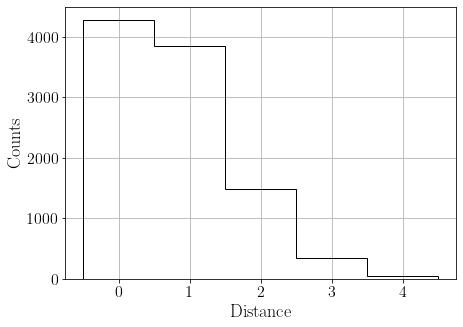

Num. of samples @ dist = 0:	 4279
Num. of samples @ dist = 1:	 3845
Num. of samples @ dist = 2:	 1488
Num. of samples @ dist = 3:	 345
Num. of samples @ dist = 4:	 40


In [35]:
M = best_parameters['M']
mini = best_parameters['minibatch']
beta = best_parameters['beta']
SPIN = True

v, v_r, w, a, b, vmin, GAP = initialize(v0, v_r, SPIN, M)
d0 = distance(v, v_r, N, GAP)
if SPIN:
    v0 = v0*2 - 1

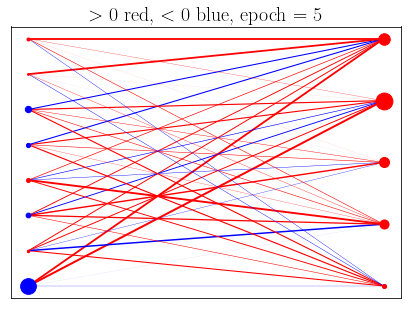

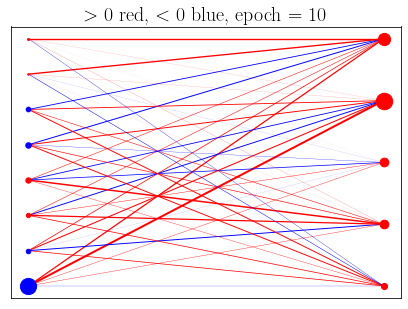

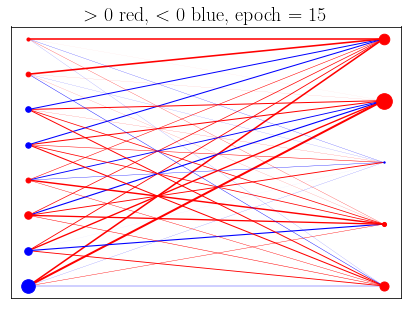

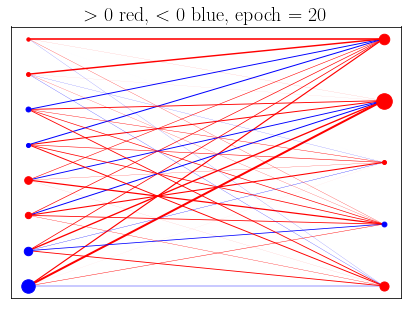

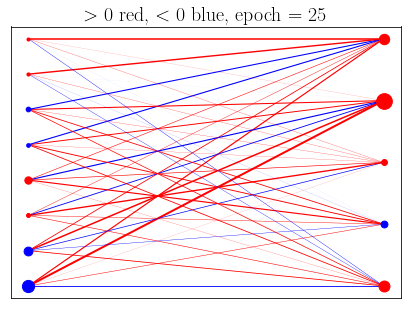

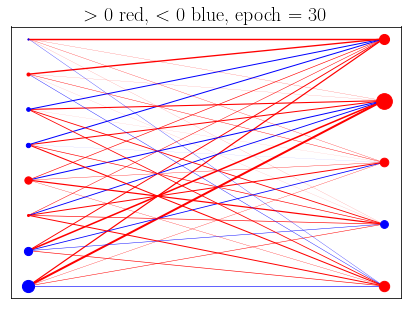

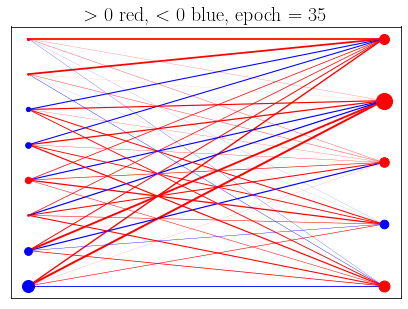

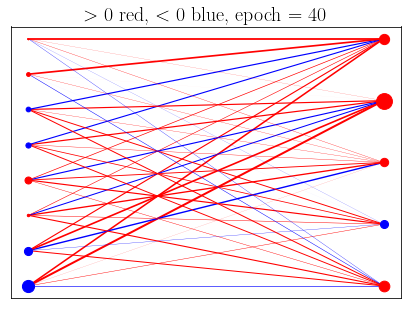

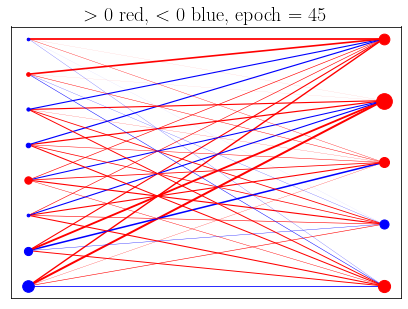

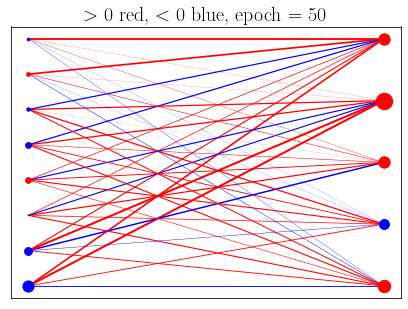

In [36]:
a, b, w, dw, prob_hidden, prob_vis = train_RBM(v, a, b, w, vmin, GAP, nepoch, mini, M)

### Generate fantasy data and check bit correction: positive and negative phase

In [39]:
fd = np.full((N,L), vmin)

for n in range(N):
    h, p_h = activate(v0[n], w, b, GAP, vmin, beta=beta)
    fd[n], p_fd = activate(h, w.T, a, GAP, vmin, beta=beta)

In [40]:
plausibility(fd, GAP, N, fourth=True)

Number of plausible samples: 76.11%
Number of not plausible samples: 23.89%


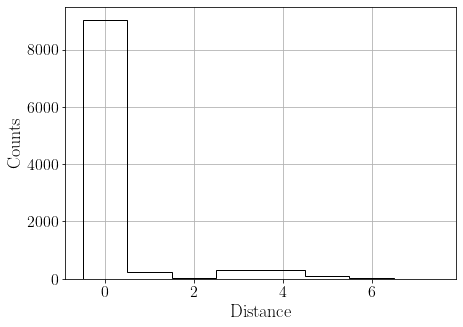

Num. of samples @ dist = 0:	 9041
Num. of samples @ dist = 1:	 224
Num. of samples @ dist = 2:	 11
Num. of samples @ dist = 3:	 310
Num. of samples @ dist = 4:	 318
Num. of samples @ dist = 5:	 85
Num. of samples @ dist = 6:	 9
Num. of samples @ dist = 7:	 1


In [41]:
d = distance(fd, v_r, N, GAP)

Mean distance real/corrupted samples: 0.803
Mean distance real/new samples: 0.294


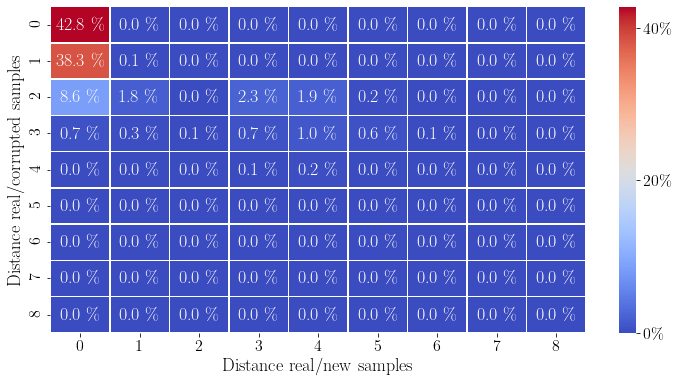

Fraction of sample not truly corrected: 9.59%


In [42]:
not_corr = dist_heatmap(d0,d)

## 1.2. Introducing more categories: $6$ sample categories

In [43]:
n_categ = 6
max_flip = 0

for i in range(1,9):
    flips = binom.pmf(i, 8, q) * N
    if flips < 1 and max_flip == 0:
        max_flip = i-1

print('# categories with %i flips: %i \t\tprobability of %i flips: %.2f%%'%(0, 6, 0, 100*binom.pmf(0,8,q)))
for i in range(1, max_flip+1):
    n_categ = n_categ + 6*factorial(8)/factorial(8-i)/factorial(i)
    print('# categories with %i flips: %i \t\tprobability of %i flips: %.2f%%'%(i, n_categ, i, 100*binom.pmf(i,8,q)))

# categories with 0 flips: 6 		probability of 0 flips: 43.05%
# categories with 1 flips: 54 		probability of 1 flips: 38.26%
# categories with 2 flips: 222 		probability of 2 flips: 14.88%
# categories with 3 flips: 558 		probability of 3 flips: 3.31%
# categories with 4 flips: 978 		probability of 4 flips: 0.46%
# categories with 5 flips: 1314 		probability of 5 flips: 0.04%


In [44]:
SPIN = [True]
M = [3,4,5,6]
minis = [54, 222, 558, 700]
betas = [0.5, 1, 10, 20]

v0, v_r = gen_data2(q, 6), gen_data2(0, 6)
best_parameters = grid(v0, v_r, SPIN, M, nepoch, minis, betas)

SPIN: True M: 3  minibatch: 54  beta: 0.5 	distance: 2.534
SPIN: True M: 3  minibatch: 54  beta: 1 	distance: 1.755
SPIN: True M: 3  minibatch: 54  beta: 10 	distance: 0.882
SPIN: True M: 3  minibatch: 54  beta: 20 	distance: 0.907
SPIN: True M: 3  minibatch: 222  beta: 0.5 	distance: 2.732
SPIN: True M: 3  minibatch: 222  beta: 1 	distance: 1.824
SPIN: True M: 3  minibatch: 222  beta: 10 	distance: 0.930
SPIN: True M: 3  minibatch: 222  beta: 20 	distance: 0.903
SPIN: True M: 3  minibatch: 558  beta: 0.5 	distance: 2.640
SPIN: True M: 3  minibatch: 558  beta: 1 	distance: 1.694
SPIN: True M: 3  minibatch: 558  beta: 10 	distance: 0.804
SPIN: True M: 3  minibatch: 558  beta: 20 	distance: 0.792
SPIN: True M: 3  minibatch: 700  beta: 0.5 	distance: 2.674
SPIN: True M: 3  minibatch: 700  beta: 1 	distance: 1.699
SPIN: True M: 3  minibatch: 700  beta: 10 	distance: 0.746
SPIN: True M: 3  minibatch: 700  beta: 20 	distance: 0.741
SPIN: True M: 4  minibatch: 54  beta: 0.5 	distance: 2.372
S

In [45]:
best_parameters

{'SPIN': True, 'M': 6, 'minibatch': 222, 'beta': 10}

In [46]:
#best_parameters = {'SPIN': True, 'M': 6, 'minibatch': 222, 'beta': 10}

### Generate data and train RBM

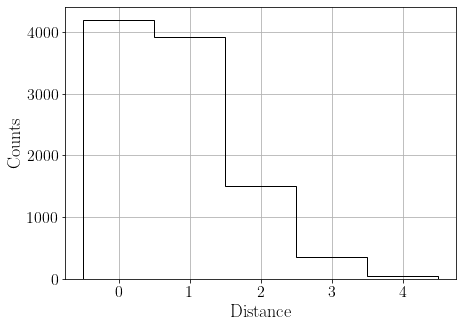

Num. of samples @ dist = 0:	 4197
Num. of samples @ dist = 1:	 3918
Num. of samples @ dist = 2:	 1497
Num. of samples @ dist = 3:	 344
Num. of samples @ dist = 4:	 42


In [47]:
M = best_parameters['M']
mini = best_parameters['minibatch']
beta = best_parameters['beta']
SPIN = True

v, v_r, w, a, b, vmin, GAP = initialize(v0, v_r, SPIN, M)
d0 = distance(v, v_r, N, GAP)
if SPIN:
    v0 = v0*2 - 1

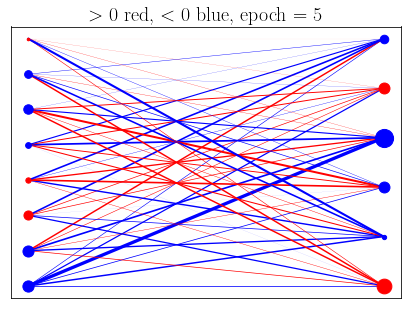

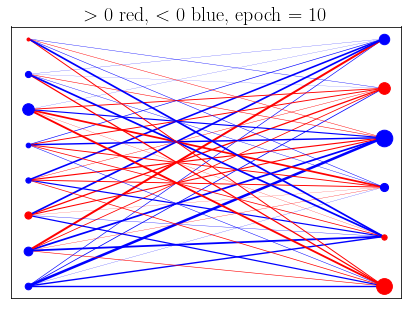

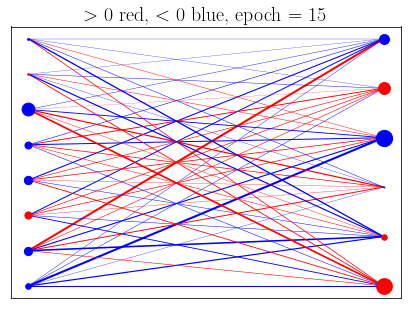

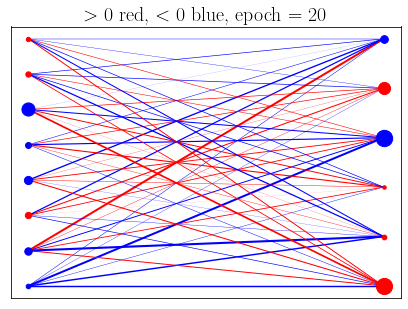

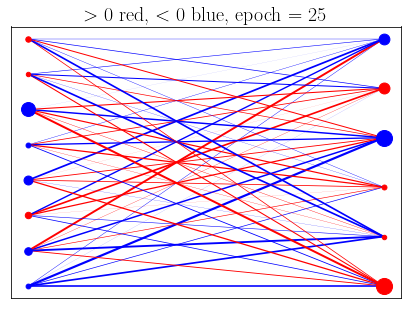

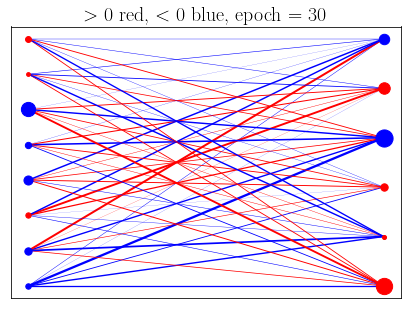

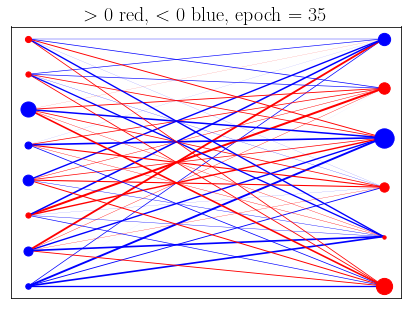

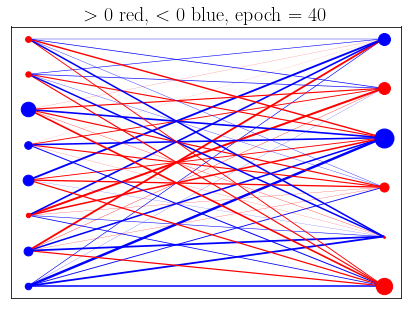

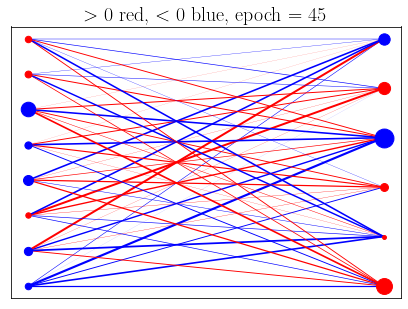

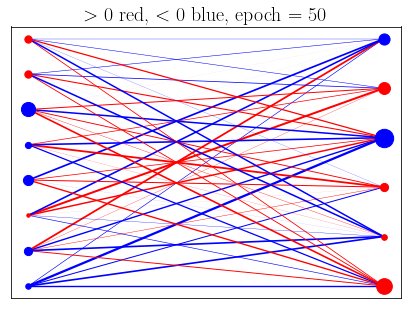

In [48]:
a, b, w, dw, prob_hidden, prob_vis = train_RBM(v, a, b, w, vmin, GAP, nepoch, mini, M)

### Generate fantasy data and check bit correction: positive and negative phase

In [51]:
fd = np.full((N,L), vmin)

for n in range(N):
    h, p_h = activate(v0[n], w, b, GAP, vmin, beta=beta)
    fd[n], p_fd = activate(h, w.T, a, GAP, vmin, beta=beta)

In [52]:
plausibility(fd, GAP, N, fifth=True)

Number of plausible samples: 75.03%
Number of not plausible samples: 24.97%


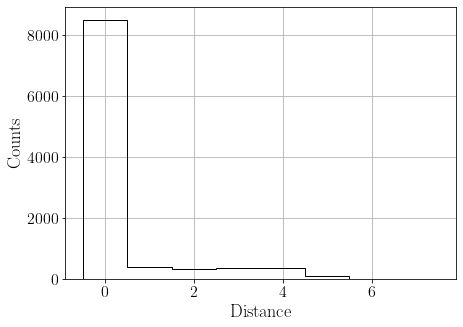

Num. of samples @ dist = 0:	 8506
Num. of samples @ dist = 1:	 369
Num. of samples @ dist = 2:	 320
Num. of samples @ dist = 3:	 366
Num. of samples @ dist = 4:	 353
Num. of samples @ dist = 5:	 81
Num. of samples @ dist = 6:	 1
Num. of samples @ dist = 7:	 3


In [53]:
d = distance(fd, v_r, N, GAP)

By adding another category, the percentage of correctly reconstructed samples decreases to 85%.

Mean distance real/corrupted samples: 0.812
Mean distance real/new samples: 0.396


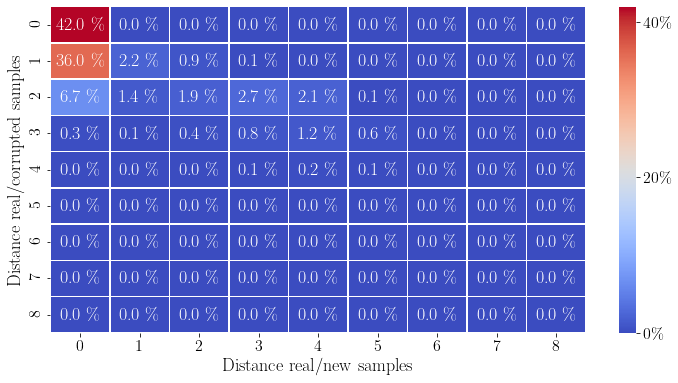

Fraction of sample not truly corrected: 14.94%


In [54]:
not_corr = dist_heatmap(d0,d)

As it can be seen from the results above, in all cases ($4$,$5$ and $6$ categories) the mean distance is greatly reduced. This means that the RBM is successfully denoising the samples and reconstructing the original data. <br>
As for when data reconstruction isn't successful, we can see for example in the case of $4$ categories that RBM struggles in particular with data having $4$ bit flipped at the beginning, for which in $60\%$ of cases ($3.3\%$ of total) it gives back a vector at distance $2$ from the actual sample without noise.

# 2. Second training: data in $\{-1, 1\}$, $q = 0.2$

## 2.1. Base case: $4$ sample categories

We now increase the probability of flipping a bit: this results in a higher quantity of noise in the samples, as can be seen by the histograms of the generated data, where there are more samples that have seen at least one of their bits flipped, as opposed to the case of $q=0.1$.

In [55]:
q = 0.2
nepoch = 50

n_categ = 4

In [56]:
SPIN = [True]
M = [2,3,4]
minis = [36, 50, 148, 372, 500]
betas = [0.5, 1, 10, 20]

v0, v_r = gen_data(q)
best_parameters = grid(v0, v_r, SPIN, M, nepoch, minis, betas)

SPIN: True M: 2  minibatch: 36  beta: 0.5 	distance: 3.220
SPIN: True M: 2  minibatch: 36  beta: 1 	distance: 2.331
SPIN: True M: 2  minibatch: 36  beta: 10 	distance: 0.957
SPIN: True M: 2  minibatch: 36  beta: 20 	distance: 0.938
SPIN: True M: 2  minibatch: 50  beta: 0.5 	distance: 3.181
SPIN: True M: 2  minibatch: 50  beta: 1 	distance: 2.168
SPIN: True M: 2  minibatch: 50  beta: 10 	distance: 0.842
SPIN: True M: 2  minibatch: 50  beta: 20 	distance: 0.837
SPIN: True M: 2  minibatch: 148  beta: 0.5 	distance: 3.204
SPIN: True M: 2  minibatch: 148  beta: 1 	distance: 2.175
SPIN: True M: 2  minibatch: 148  beta: 10 	distance: 0.829
SPIN: True M: 2  minibatch: 148  beta: 20 	distance: 0.832
SPIN: True M: 2  minibatch: 372  beta: 0.5 	distance: 3.210
SPIN: True M: 2  minibatch: 372  beta: 1 	distance: 2.176
SPIN: True M: 2  minibatch: 372  beta: 10 	distance: 0.836
SPIN: True M: 2  minibatch: 372  beta: 20 	distance: 0.834
SPIN: True M: 2  minibatch: 500  beta: 0.5 	distance: 3.201
SPIN

In [57]:
best_parameters

{'SPIN': True, 'M': 2, 'minibatch': 500, 'beta': 20}

In [58]:
#best_parameters = {'SPIN': True, 'M': 2, 'minibatch': 500, 'beta': 20}

### Generate data and train RBM

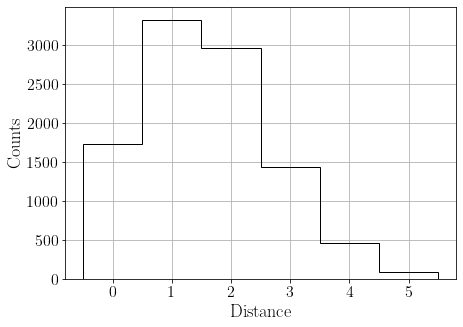

Num. of samples @ dist = 0:	 1724
Num. of samples @ dist = 1:	 3322
Num. of samples @ dist = 2:	 2961
Num. of samples @ dist = 3:	 1435
Num. of samples @ dist = 4:	 459
Num. of samples @ dist = 5:	 90


In [59]:
M = best_parameters['M']
mini = best_parameters['minibatch']
beta = best_parameters['beta']
SPIN = True

v, v_r, w, a, b, vmin, GAP = initialize(v0, v_r, SPIN, M)
d0 = distance(v, v_r, N, GAP)
if SPIN:
    v0 = v0*2 - 1

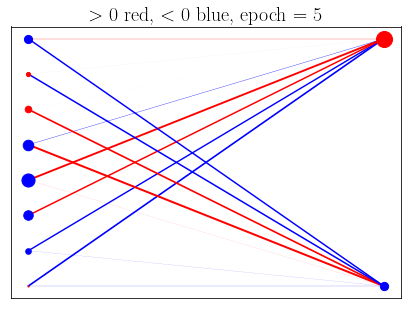

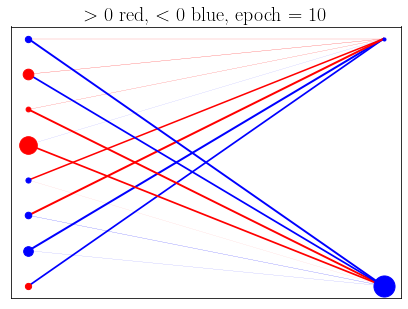

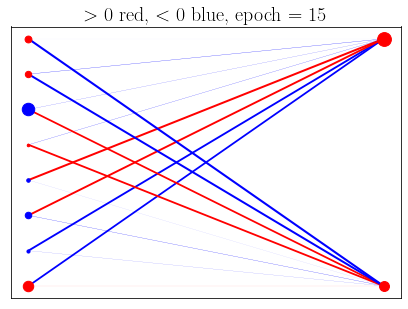

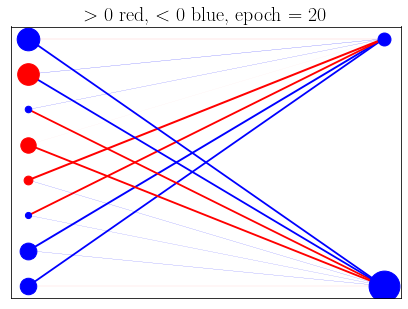

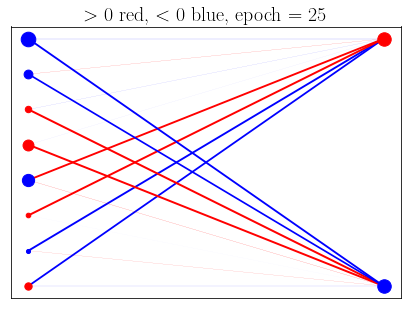

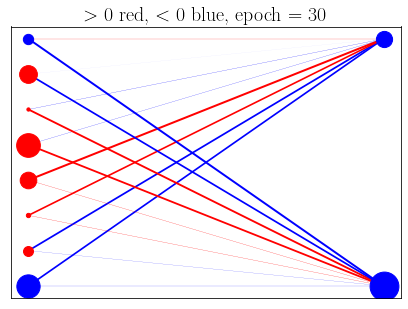

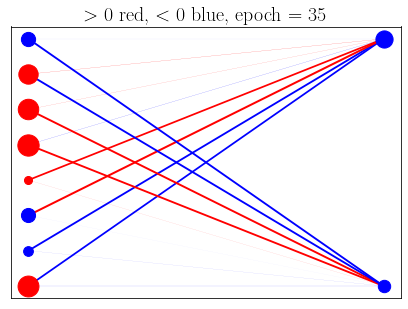

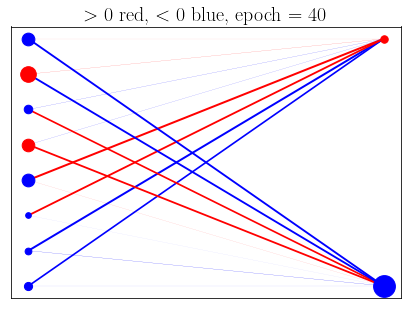

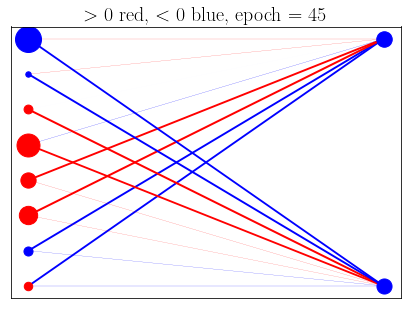

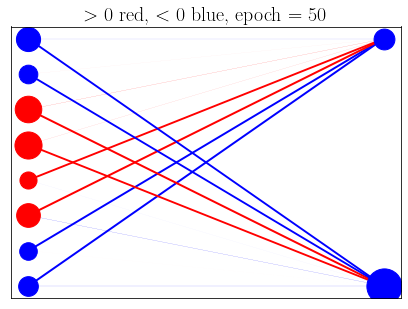

In [60]:
a, b, w, dw, prob_hidden, prob_vis = train_RBM(v, a, b, w, vmin, GAP, nepoch, mini, M)

### Generate fantasy data and check bit correction: positive and negative phase

In [63]:
fd = np.full((N,L), vmin)

for n in range(N):
    h, p_h = activate(v0[n], w, b, GAP, vmin, beta=beta)
    fd[n], p_fd = activate(h, w.T, a, GAP, vmin, beta=beta)

In [64]:
plausibility(fd, GAP, N)

Number of plausible samples: 100.00%
Number of not plausible samples: 0.00%


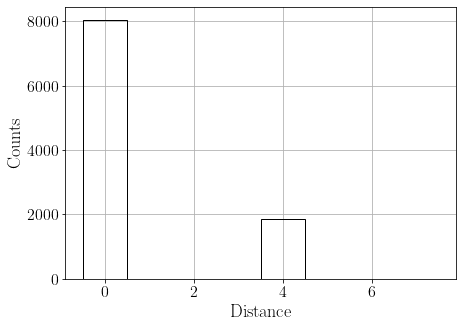

Num. of samples @ dist = 0:	 8049
Num. of samples @ dist = 1:	 0
Num. of samples @ dist = 2:	 0
Num. of samples @ dist = 3:	 0
Num. of samples @ dist = 4:	 1849
Num. of samples @ dist = 5:	 0
Num. of samples @ dist = 6:	 0
Num. of samples @ dist = 7:	 0


In [65]:
d = distance(fd, v_r, N, GAP)

Mean distance real/corrupted samples: 1.589
Mean distance real/new samples: 0.821


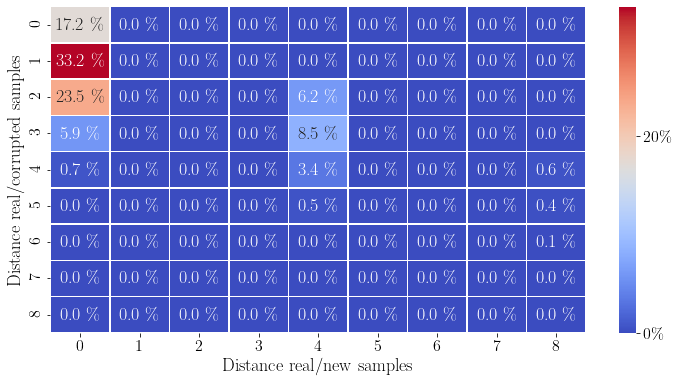

Fraction of sample not truly corrected: 19.51%


In [66]:
not_corr = dist_heatmap(d0,d)

First of all it can be noticed that the function  `grid()` selects $M=2$ as number of hidden units as one could intuitively think, since the samples in this section are generated from a set of strings that are structured depending on $2$ hidden variables ($a,b$ in the function  `gen_data()`).

Since the probability of bit-flipping is higher, the histogram of the distances between the original and the corrupted data is more spread than in the previous cases (now the percentage of input samples with at least $1$ flip is about $83\%$). For this reason it could be more difficult for the machine to understand the hidden structure of data.<br>
By looking at the histogram of distances between the original and fantasy sample it can be noticed that in this case there are only $2$ scenarios: either the machine corrects the noise or generates a sample with $4$ errors.
From the previous heatmap it can be observed that when the sample that the RMB takes in input presents only $1$ bit-flip, the error is is always recognized and corrected. When the input sample presents $2$ bit-flips in most of the cases the machine can recognize the error, but in some unlucky situations (the $6.2\%$ of the total cases) the machine generates a different sequence that presents $4$ errors. Since in this case all of the fantasy data result "plausible", these wrong data are still one of the sequences with which the inital data were generated. When the input sample presents $3$ bit-flips it can be noticed that it's more likely to correct it by wrongly flipping another bit ($8.5\%$) than to correct it in the right way ($5.9\%$). 
From a general point of view it can be observed that the percentage of sample corrected in the wrong way by this RBM is $19.51\%$ that is higher than all the previous ones.
However, the mean distance from the original sample is reduced a lot, going from $1.6$ to $0.8$ when considering fantasy data.

## 2.2. Introducing more categories: $5$ sample categories

In [67]:
n_categ = 5

In [68]:
SPIN = [True]
M = [3,4,5,6]
minis = [45,185,465,600]
betas = [0.5, 1, 10, 20]

v0, v_r = gen_data2(q, 5), gen_data2(0, 5)
best_parameters = grid(v0, v_r, SPIN, M, nepoch, minis, betas)

SPIN: True M: 3  minibatch: 45  beta: 0.5 	distance: 3.196
SPIN: True M: 3  minibatch: 45  beta: 1 	distance: 2.437
SPIN: True M: 3  minibatch: 45  beta: 10 	distance: 1.235
SPIN: True M: 3  minibatch: 45  beta: 20 	distance: 1.221
SPIN: True M: 3  minibatch: 185  beta: 0.5 	distance: 3.240
SPIN: True M: 3  minibatch: 185  beta: 1 	distance: 2.414
SPIN: True M: 3  minibatch: 185  beta: 10 	distance: 1.130
SPIN: True M: 3  minibatch: 185  beta: 20 	distance: 1.124
SPIN: True M: 3  minibatch: 465  beta: 0.5 	distance: 3.257
SPIN: True M: 3  minibatch: 465  beta: 1 	distance: 2.429
SPIN: True M: 3  minibatch: 465  beta: 10 	distance: 1.071
SPIN: True M: 3  minibatch: 465  beta: 20 	distance: 1.061
SPIN: True M: 3  minibatch: 600  beta: 0.5 	distance: 3.240
SPIN: True M: 3  minibatch: 600  beta: 1 	distance: 2.403
SPIN: True M: 3  minibatch: 600  beta: 10 	distance: 1.048
SPIN: True M: 3  minibatch: 600  beta: 20 	distance: 1.050
SPIN: True M: 4  minibatch: 45  beta: 0.5 	distance: 3.216
S

In [69]:
best_parameters

{'SPIN': True, 'M': 6, 'minibatch': 185, 'beta': 20}

In [70]:
#best_parameters = {'SPIN': True, 'M': 6, 'minibatch': 185, 'beta': 20}

### Generate data and train RBM

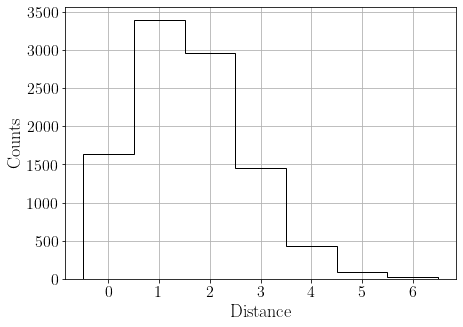

Num. of samples @ dist = 0:	 1641
Num. of samples @ dist = 1:	 3400
Num. of samples @ dist = 2:	 2967
Num. of samples @ dist = 3:	 1454
Num. of samples @ dist = 4:	 434
Num. of samples @ dist = 5:	 86
Num. of samples @ dist = 6:	 17


In [71]:
M = best_parameters['M']
mini = best_parameters['minibatch']
beta = best_parameters['beta']
SPIN = True

v, v_r, w, a, b, vmin, GAP = initialize(v0, v_r, SPIN, M)
d0 = distance(v, v_r, N, GAP)
if SPIN:
    v0 = v0*2 - 1

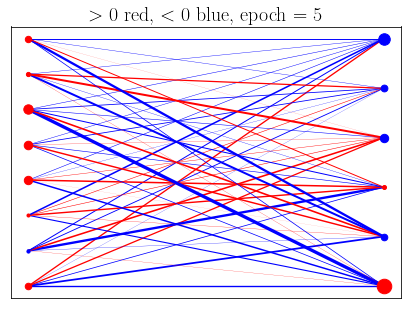

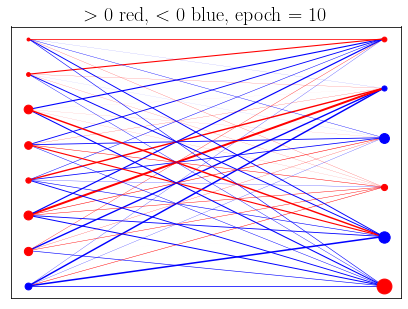

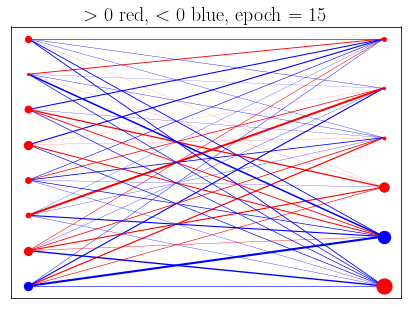

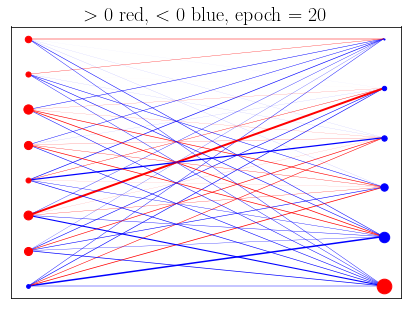

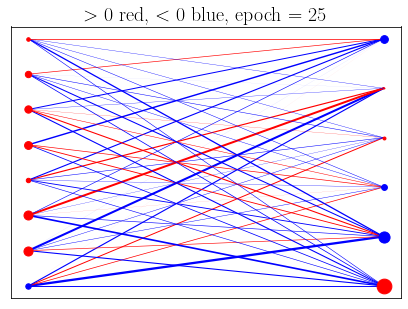

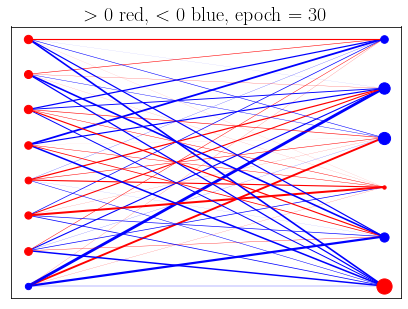

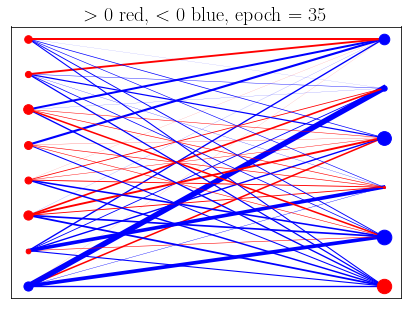

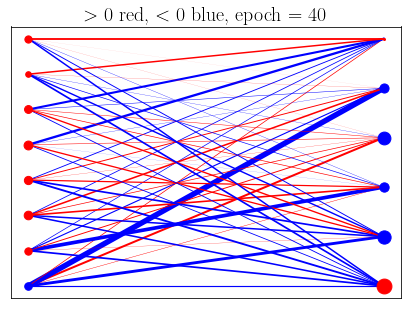

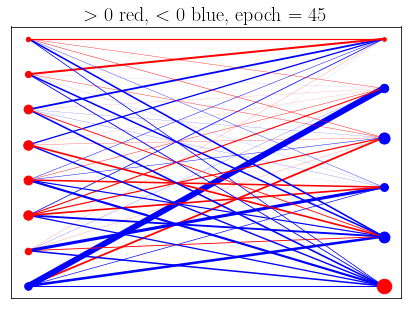

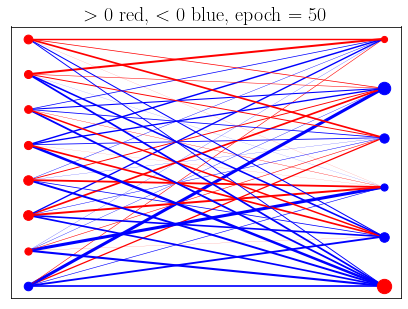

In [72]:
a, b, w, dw, prob_hidden, prob_vis = train_RBM(v, a, b, w, vmin, GAP, nepoch, mini, M)

### Generate fantasy data and check bit correction: positive and negative phase

In [75]:
fd = np.full((N,L), vmin)

for n in range(N):
    h, p_h = activate(v0[n], w, b, GAP, vmin, beta=beta)
    fd[n], p_fd = activate(h, w.T, a, GAP, vmin, beta=beta)

In [76]:
plausibility(fd, GAP, N, fourth=True)

Number of plausible samples: 60.34%
Number of not plausible samples: 39.66%


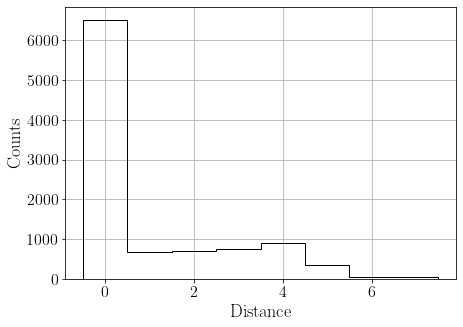

Num. of samples @ dist = 0:	 6520
Num. of samples @ dist = 1:	 671
Num. of samples @ dist = 2:	 705
Num. of samples @ dist = 3:	 753
Num. of samples @ dist = 4:	 903
Num. of samples @ dist = 5:	 352
Num. of samples @ dist = 6:	 32
Num. of samples @ dist = 7:	 41


In [77]:
d = distance(fd, v_r, N, GAP)

Mean distance real/corrupted samples: 1.597
Mean distance real/new samples: 1.038


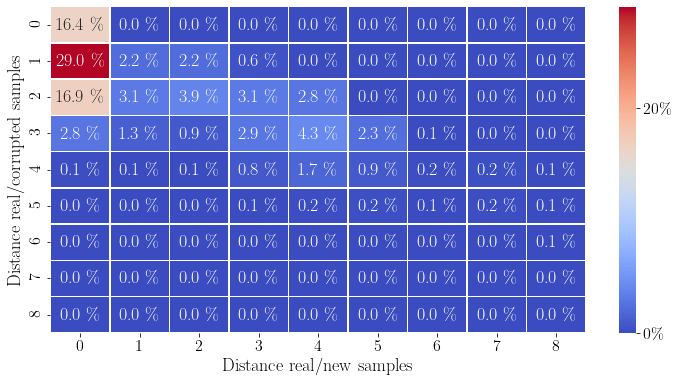

Fraction of sample not truly corrected: 34.80%


In [78]:
not_corr = dist_heatmap(d0,d)

In this case, in which the samples are genarated with the second method, the function  `grid()` selects a higher number of hidden units: $M=6$. 


Since now not all the input samples follow an hidden structure, the machine has more difficulties in identifying them and so it is more likely to commit errors in the denoising process. In fact there are many more output scenarios, as it can be seen from the last histogram and from the heatmap, and the fantasy samples considered plausible are now only $60\%$.
In general, the RBM performs worse than in the previous case: the percentage of sample corrected in the wrong way is now about $35\%$.

## 2.3. Introducing more categories: $6$ sample categories

In [79]:
n_categ = 6

In [80]:
SPIN = [True]
M = [3,4,5,6]
minis = [54, 222, 558, 700]
betas = [0.5, 1, 10, 20]

v0, v_r = gen_data2(q, 6), gen_data2(0, 6)
best_parameters = grid(v0, v_r, SPIN, M, nepoch, minis, betas)

SPIN: True M: 3  minibatch: 54  beta: 0.5 	distance: 3.530
SPIN: True M: 3  minibatch: 54  beta: 1 	distance: 2.969
SPIN: True M: 3  minibatch: 54  beta: 10 	distance: 1.930
SPIN: True M: 3  minibatch: 54  beta: 20 	distance: 1.913
SPIN: True M: 3  minibatch: 222  beta: 0.5 	distance: 3.499
SPIN: True M: 3  minibatch: 222  beta: 1 	distance: 2.843
SPIN: True M: 3  minibatch: 222  beta: 10 	distance: 1.533
SPIN: True M: 3  minibatch: 222  beta: 20 	distance: 1.516
SPIN: True M: 3  minibatch: 558  beta: 0.5 	distance: 3.479
SPIN: True M: 3  minibatch: 558  beta: 1 	distance: 2.843
SPIN: True M: 3  minibatch: 558  beta: 10 	distance: 1.590
SPIN: True M: 3  minibatch: 558  beta: 20 	distance: 1.610
SPIN: True M: 3  minibatch: 700  beta: 0.5 	distance: 3.464
SPIN: True M: 3  minibatch: 700  beta: 1 	distance: 2.801
SPIN: True M: 3  minibatch: 700  beta: 10 	distance: 1.551
SPIN: True M: 3  minibatch: 700  beta: 20 	distance: 1.563
SPIN: True M: 4  minibatch: 54  beta: 0.5 	distance: 3.268
S

In [81]:
best_parameters

{'SPIN': True, 'M': 4, 'minibatch': 222, 'beta': 20}

In [82]:
#best_parameters = {'SPIN': True, 'M': 4, 'minibatch': 222, 'beta': 20}

### Generate data and train RBM

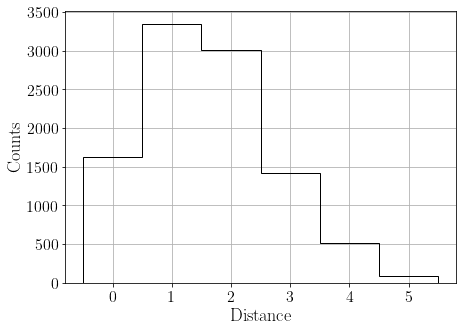

Num. of samples @ dist = 0:	 1628
Num. of samples @ dist = 1:	 3345
Num. of samples @ dist = 2:	 3001
Num. of samples @ dist = 3:	 1415
Num. of samples @ dist = 4:	 518
Num. of samples @ dist = 5:	 82


In [83]:
M = best_parameters['M']
mini = best_parameters['minibatch']
beta = best_parameters['beta']
SPIN = True

v, v_r, w, a, b, vmin, GAP = initialize(v0, v_r, SPIN, M)
d0 = distance(v, v_r, N, GAP)
if SPIN:
    v0 = v0*2 - 1

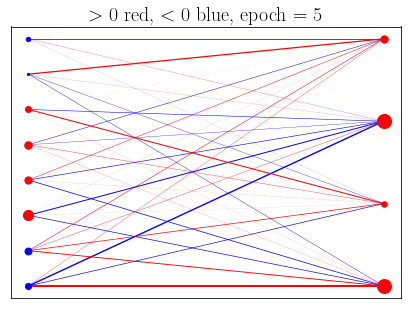

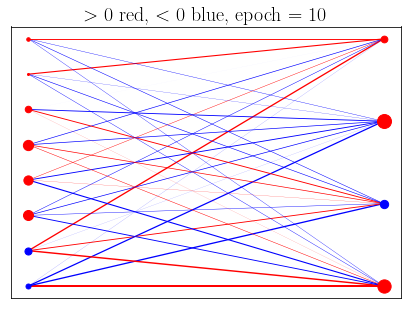

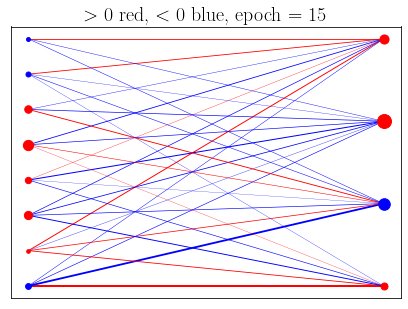

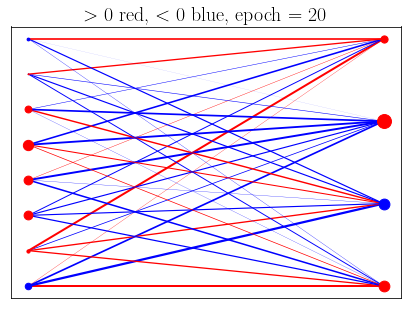

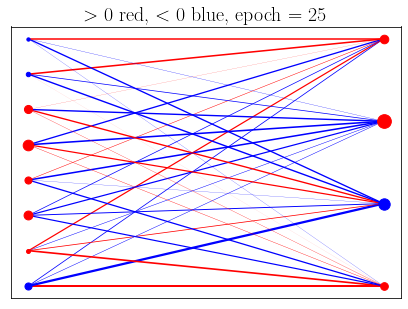

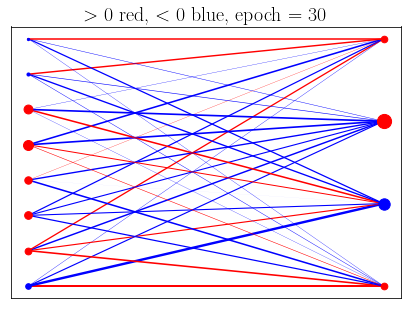

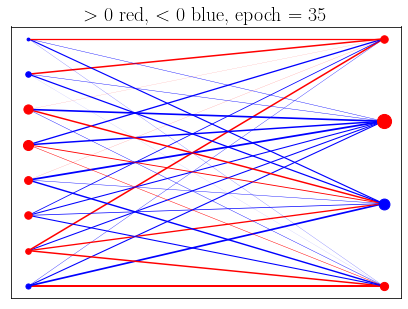

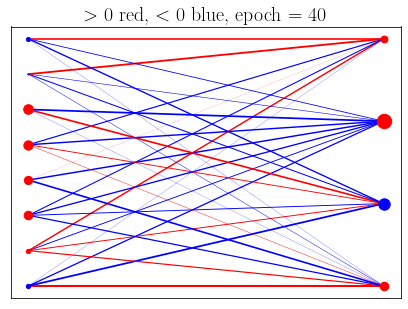

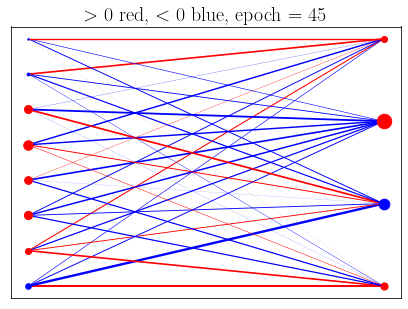

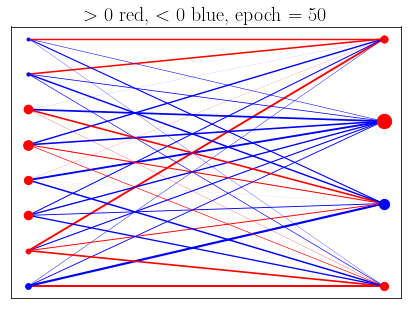

In [84]:
a, b, w, dw, prob_hidden, prob_vis = train_RBM(v, a, b, w, vmin, GAP, nepoch, mini, M)

### Generate fantasy data and check bit correction: positive and negative phase

In [87]:
fd = np.full((N,L), vmin)

for n in range(N):
    h, p_h = activate(v0[n], w, b, GAP, vmin, beta=beta)
    fd[n], p_fd = activate(h, w.T, a, GAP, vmin, beta=beta)

In [88]:
plausibility(fd, GAP, N, fifth=True)

Number of plausible samples: 68.77%
Number of not plausible samples: 31.23%


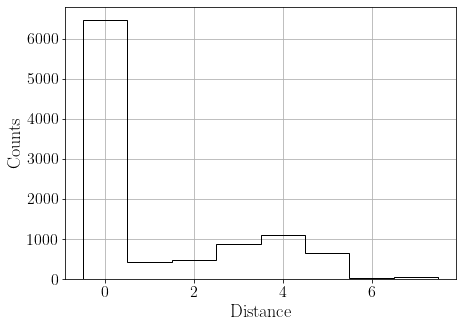

Num. of samples @ dist = 0:	 6467
Num. of samples @ dist = 1:	 418
Num. of samples @ dist = 2:	 458
Num. of samples @ dist = 3:	 862
Num. of samples @ dist = 4:	 1085
Num. of samples @ dist = 5:	 636
Num. of samples @ dist = 6:	 5
Num. of samples @ dist = 7:	 41


In [89]:
d = distance(fd, v_r, N, GAP)

Mean distance real/corrupted samples: 1.614
Mean distance real/new samples: 1.198


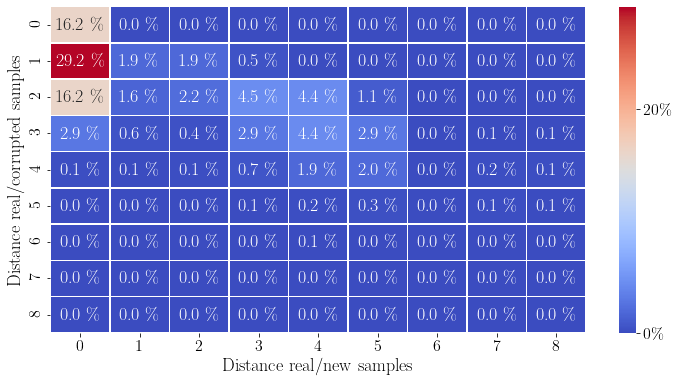

Fraction of sample not truly corrected: 35.33%


In [90]:
not_corr = dist_heatmap(d0,d)

The optimal number of hidden units is now $M=4$, which is smaller than the one of the previous paragraph. However, this should not arise suspicion because the RBM is trying to find a hidden structure in a datset that does not have any, and so it is not easy to predict which is the number of the M parameter that we expect.

The performances are slightly worse but comparable to the case of $5$ categories. The percentage of samples corrected in the wrong way is still $35\%$, and the mean distance from the original samples is not much reduced when considering fantasy data, going from $1.6$ to $1.1$.

# 3. Third training: data in $\{0, 1\}$, $q = 0.1$

In [91]:
q = 0.1
n_categ = 4
max_flip = 0
nepoch = 50

for i in range(1,9):
    flips = binom.pmf(i, 8, q) * N
    if flips < 1 and max_flip == 0:
        max_flip = i-1

print('# categories with %i flips: %i \t\tprobability of %i flips: %.2f%%'%(0, 4, 0, 100*binom.pmf(0,8,q)))
for i in range(1, max_flip+1):
    n_categ = n_categ + 4*factorial(8)/factorial(8-i)/factorial(i)
    print('# categories with %i flips: %i \t\tprobability of %i flips: %.2f%%'%(i, n_categ, i, 100*binom.pmf(i,8,q)))

# categories with 0 flips: 4 		probability of 0 flips: 43.05%
# categories with 1 flips: 36 		probability of 1 flips: 38.26%
# categories with 2 flips: 148 		probability of 2 flips: 14.88%
# categories with 3 flips: 372 		probability of 3 flips: 3.31%
# categories with 4 flips: 652 		probability of 4 flips: 0.46%
# categories with 5 flips: 876 		probability of 5 flips: 0.04%


In [95]:
SPIN = [False]
M = [2,3,4]
minis = [36, 50, 150, 372, 500]
betas = [0.5, 1, 10, 20]

v0, v_r = gen_data(q)
best_parameters = grid(v0, v_r, SPIN, M, nepoch, minis, betas)

SPIN: False M: 2  minibatch: 36  beta: 0.5 	distance: 2.262
SPIN: False M: 2  minibatch: 36  beta: 1 	distance: 0.991
SPIN: False M: 2  minibatch: 36  beta: 10 	distance: 0.234
SPIN: False M: 2  minibatch: 36  beta: 20 	distance: 0.222
SPIN: False M: 2  minibatch: 50  beta: 0.5 	distance: 2.267
SPIN: False M: 2  minibatch: 50  beta: 1 	distance: 0.993
SPIN: False M: 2  minibatch: 50  beta: 10 	distance: 0.238
SPIN: False M: 2  minibatch: 50  beta: 20 	distance: 0.244
SPIN: False M: 2  minibatch: 150  beta: 0.5 	distance: 2.280
SPIN: False M: 2  minibatch: 150  beta: 1 	distance: 1.002
SPIN: False M: 2  minibatch: 150  beta: 10 	distance: 0.239
SPIN: False M: 2  minibatch: 150  beta: 20 	distance: 0.240
SPIN: False M: 2  minibatch: 372  beta: 0.5 	distance: 2.277
SPIN: False M: 2  minibatch: 372  beta: 1 	distance: 1.001
SPIN: False M: 2  minibatch: 372  beta: 10 	distance: 0.236
SPIN: False M: 2  minibatch: 372  beta: 20 	distance: 0.244
SPIN: False M: 2  minibatch: 500  beta: 0.5 	dis

In [96]:
best_parameters

{'SPIN': False, 'M': 4, 'minibatch': 500, 'beta': 20}

In [97]:
#best_parameters = {'SPIN': False, 'M': 4, 'minibatch': 500, 'beta': 20}

### Generate data and train RBM

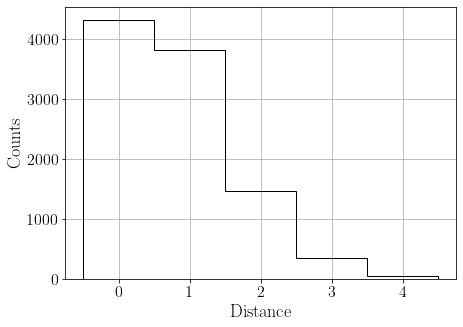

Num. of samples @ dist = 0:	 4321
Num. of samples @ dist = 1:	 3816
Num. of samples @ dist = 2:	 1468
Num. of samples @ dist = 3:	 349
Num. of samples @ dist = 4:	 42


In [98]:
M = best_parameters['M']
mini = best_parameters['minibatch']
beta = best_parameters['beta']
SPIN = True

v, v_r, w, a, b, vmin, GAP = initialize(v0, v_r, SPIN, M)
d0 = distance(v, v_r, N, GAP)
if SPIN:
    v0 = v0*2 - 1

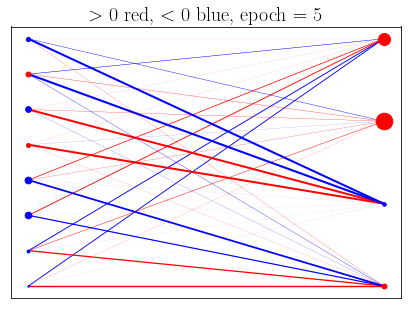

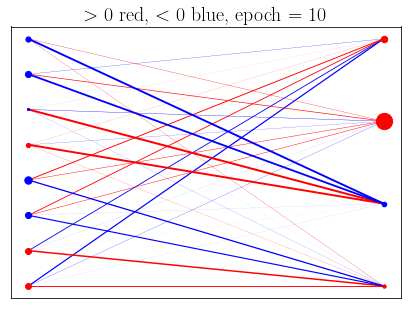

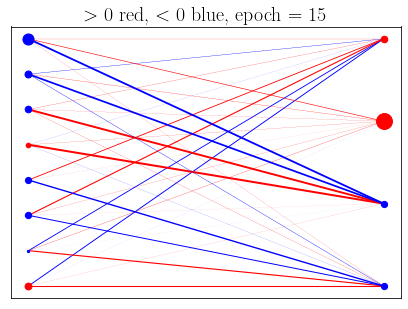

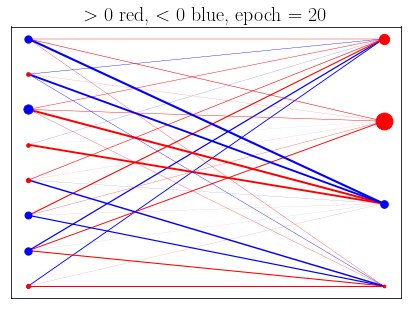

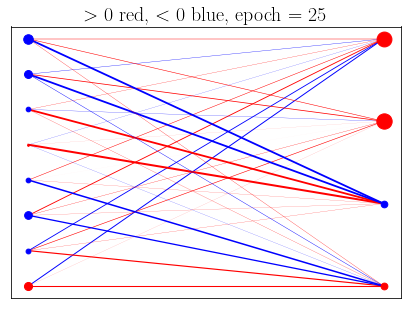

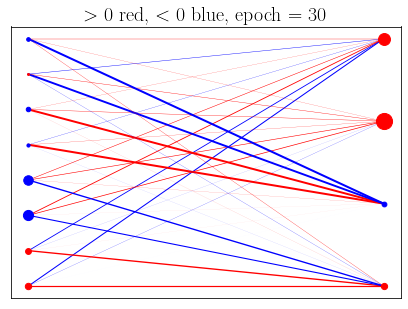

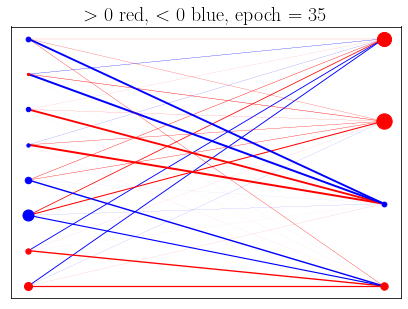

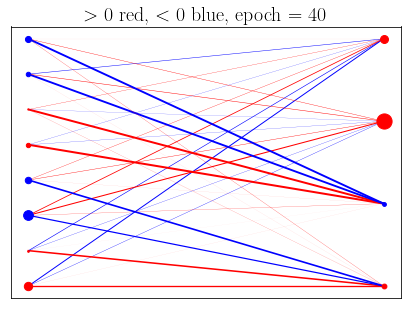

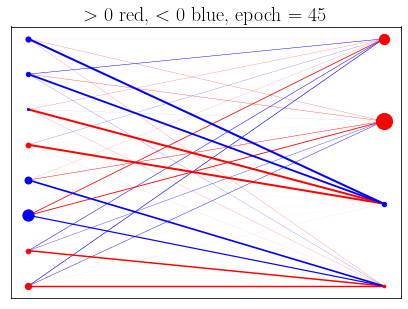

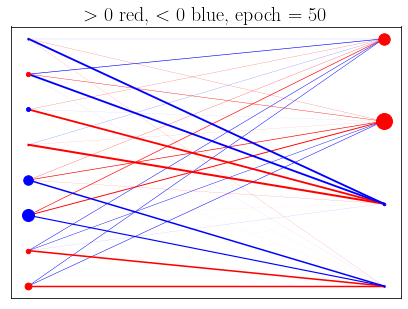

In [99]:
a, b, w, dw, prob_hidden, prob_vis = train_RBM(v, a, b, w, vmin, GAP, nepoch, mini, M)

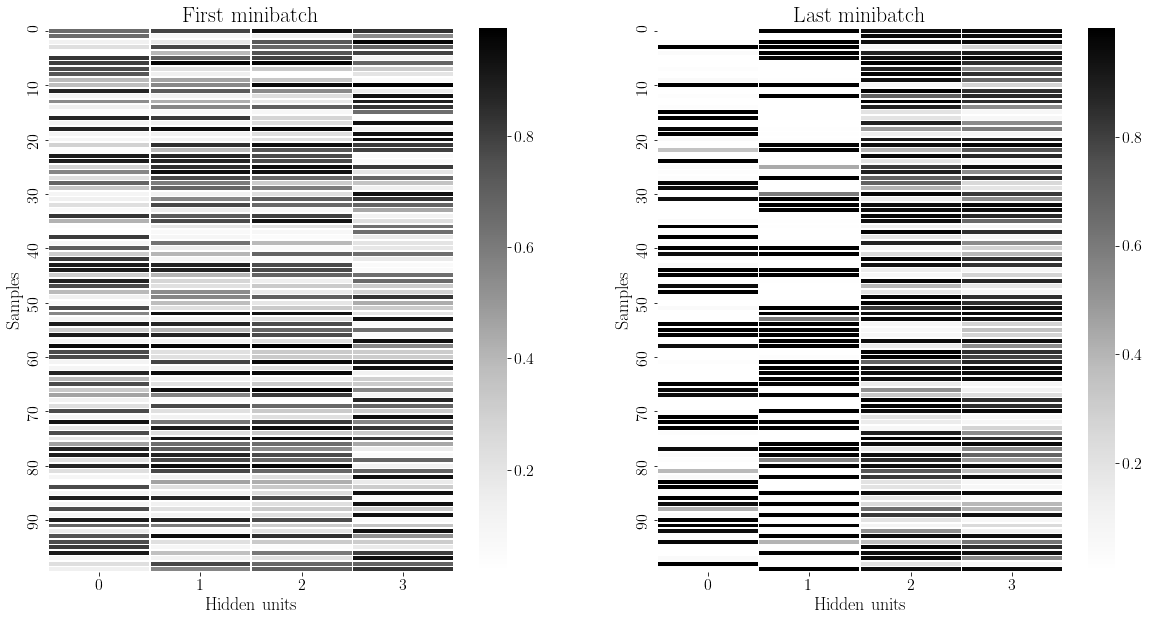

In [100]:
prob_heatmap(prob_hidden, 100)

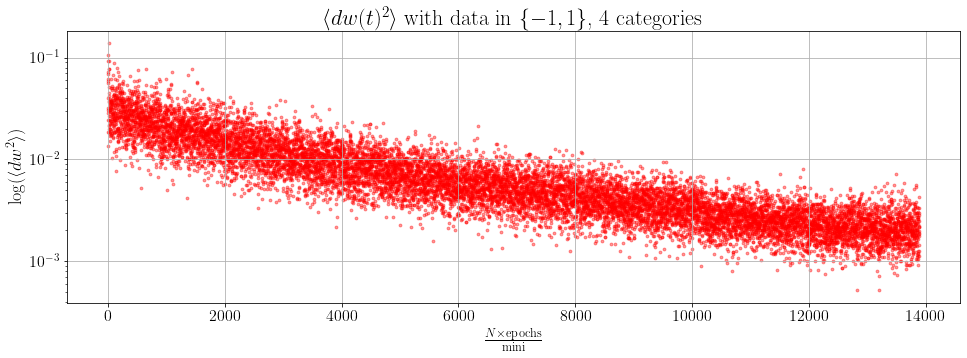

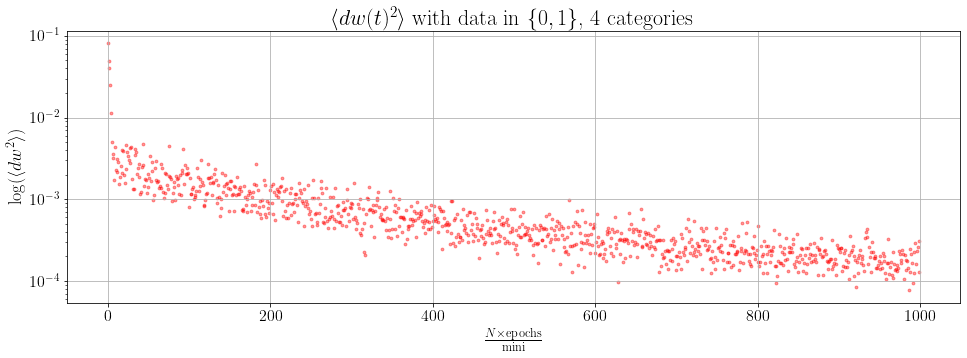

In [101]:
plot_weights(N, first_mini, nepoch, first_dw, title=r'$\langle dw(t)^2\rangle$ with data in $\{-1, 1\}$, $4$ categories')
plot_weights(N, mini, nepoch, dw, title=r'$\langle dw(t)^2\rangle$ with data in $\{0, 1\}$, $4$ categories')

### Generate fantasy data and check bit correction: positive and negative phase

In [102]:
fd = np.full((N,L), vmin)

for n in range(N):
    h, p_h = activate(v0[n], w, b, GAP, vmin, beta=beta)
    fd[n], p_fd = activate(h, w.T, a, GAP, vmin, beta=beta)

In [103]:
plausibility(fd, GAP, N)

Number of plausible samples: 98.41%
Number of not plausible samples: 1.59%


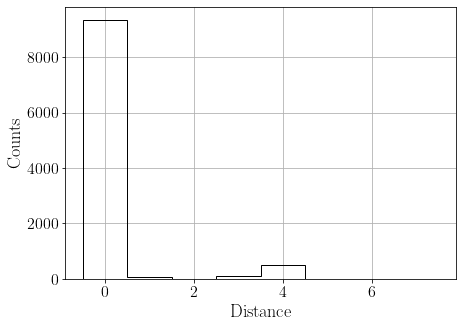

Num. of samples @ dist = 0:	 9350
Num. of samples @ dist = 1:	 72
Num. of samples @ dist = 2:	 0
Num. of samples @ dist = 3:	 84
Num. of samples @ dist = 4:	 482
Num. of samples @ dist = 5:	 1
Num. of samples @ dist = 6:	 0
Num. of samples @ dist = 7:	 2


In [104]:
d = distance(fd, v_r, N, GAP)

Mean distance real/corrupted samples: 0.799
Mean distance real/new samples: 0.234


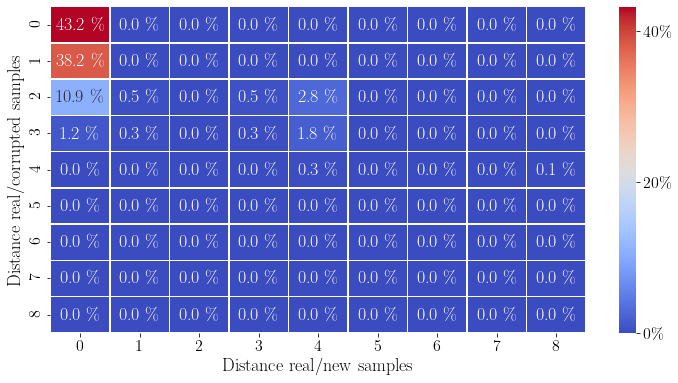

Fraction of sample not truly corrected: 6.50%


In [105]:
not_corr = dist_heatmap(d0,d)

Looking at the graphics of the weights increment, the general trend is decreasing for both cases (i.e. spin and bit encoding) and convergence is reached. However, in the bit encoding case the curve drop is more rapid and a smaller value of the increment is reached.<br>
Observing the heatmap it can be noticed that the performances are comparable to the respective spin encoding case, though sligthly worse.

## Summary table

In the following table we present the main results obtained during this analysis.<br>
As expected, the higher $q$ used to corrupt the data the worse the performance of the network becomes. Fixing the value of $q$ the percentage of corrected samples is highest when a specific structure is present in the data (i.e. the base case of $4$ categories).<br>
Through the different cases we have observed that the value of different training parameters has a small incidence on the performance of the machine as opposed to the underlying structure of the data.

In all cases the mean distance decreases following the denoising process.

|| $\langle d\rangle$ not corrupted/corrupted | $\langle d\rangle$ not corrupted/fantasy data | % of corrected samples |
| :- | -: | -: | :-: |
| $$q=0.1$$ $$4\ cat.$$ $$\{-1,1\}$$ | 0.799 | 0.229 | 94.34 %
| $$q=0.1$$ $$5\ cat.$$ $$\{-1,1\}$$ | 0.803 | 0.294 | 90.41 %
| $$q=0.1$$ $$6\ cat.$$ $$\{-1,1\}$$ | 0.812 | 0.396 | 85.06 %
| $$q=0.2$$ $$4\ cat.$$ $$\{-1,1\}$$ | 1.589 | 0.821 | 80.49 %
| $$q=0.2$$ $$5\ cat.$$ $$\{-1,1\}$$ | 1.597 | 1.038 | 65.20 %
| $$q=0.2$$ $$6\ cat.$$ $$\{-1,1\}$$ | 1.614 | 1.198 | 64.67 %